## Final Project Submission

- Student Name: Lisa Arends
- Student pace: full time
- Instructor: Claude Fried
- Blog post URL: https://fromteachingtotech928923879.wordpress.com/2021/09/03/not-so-mellow-mushrooms-a-classification-task/


# Problem Statement

Azulejos Ltd. is a boutique hotel management company that has two properties in Portugal. These two properties had 119,390 reservations made between July 1, 2015 and August 13, 2017. Of these reservations, 44,224 (37%) canceled before their scheduled arrival date.

## Business Value

On average, customers reserve a room 104 days before their anticipated arrival date. Once it is reserved, it is unavailable to other customers. As a result, cancellations can result in reduced profits if the room is unable to be re-booked before the scheduled dates. With an average daily rate of  €101.83 and an average stay length of 3.4 days, a canceled room that remains vacant costs the hotel an average of €346.22.

Currently, only 12.2% of the customers are charged a non-refundable deposit, which helps to mitigate the profit loss caused by cancellations. The hotel management company's current strategy for predicting cancellations is inferred through its deposit strategy. 99% of customers who are charged a deposit go on to cancel. This indicates that the current strategy has a high precision rate - if a customer is predicted to cancel, they almost certainly will. However, the current strategy only identifies 32% of the customers that go on to cancel, which means the majority of cancellations are not associated with a deposit that can help buffer the potential loss in profits. 

By identifying ahead of time which customers are more likely to cancel and understanding the patterns that occur in cancellations, the Azulejos Ltd. will be able to implement strategies to reduce the lost profits that result from cancellations.

## Questions to Consider

- How can we predict the customers that are most likely to cancel their reservations?
- How do cancellations vary based on other factors (time, customer-location, etc.)?
- What strategies can be implemented to mitigate the impact of cancellations on profit?

## Methodology

The data from 119,390 reservations made between July 1, 2015 and August 13, 2017 will be used to create a model that can use information about a customer and their reservation to predict if they are likely to cancel. In addition, the data will be analyzed for trends and patterns that will help to understand when and why cancellations occur. 

# Obtain the Data

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer, 
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
)


import joblib
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

In [2]:
#Create global variables for colors.
NEUTRAL = '#3a5a85ff'
POS = '#94b3e0ff'
NEG = "#9e9e9eff"
COLORS = [NEUTRAL, NEG, POS]
sns.set_palette(COLORS)
WINTER = '#648dc660'
SPRING = '#85c4ac'
SUMMER = '#fee068ff'
FALL = '#d59d00'
WHITE = '#ffffffff'


#Global variable for random state.
SEED = 85

#Global variable for class names.
CLASS_NAMES = ['not_canceled','canceled']

In [3]:
hotels = pd.read_csv('files/hotel_booking.csv',parse_dates= (
    {"arrival_date" : [
        "arrival_date_year",
        "arrival_date_month",
        "arrival_date_day_of_month"]}))
hotels.head()

,arrival_date,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,2015-07-01,Resort Hotel,0,342,27,0,0,2,0.0,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,2015-07-01,Resort Hotel,0,737,27,0,0,2,0.0,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,2015-07-01,Resort Hotel,0,7,27,0,1,1,0.0,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,2015-07-01,Resort Hotel,0,13,27,0,1,1,0.0,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,2015-07-01,Resort Hotel,0,14,27,0,2,2,0.0,0,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Initial Exploration

The data consist of 119,390 observations from either a city or resort hotel in Portugal from July 1015 to August 2017. 

In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   arrival_date                    119390 non-null  datetime64[ns]
 1   hotel                           119390 non-null  object        
 2   is_canceled                     119390 non-null  int64         
 3   lead_time                       119390 non-null  int64         
 4   arrival_date_week_number        119390 non-null  int64         
 5   stays_in_weekend_nights         119390 non-null  int64         
 6   stays_in_week_nights            119390 non-null  int64         
 7   adults                          119390 non-null  int64         
 8   children                        119386 non-null  float64       
 9   babies                          119390 non-null  int64         
 10  meal                            119390 non-null  object 

There are missing values that will need to be addressed, synthetic data (name, email, phone and credit card) that will need to be dropped and the date-related columns will need to be transformed into datetime objects so that the time of the cancellation relative to the reservation data can be calculated. 

Text(0.9, 20000, '37%')

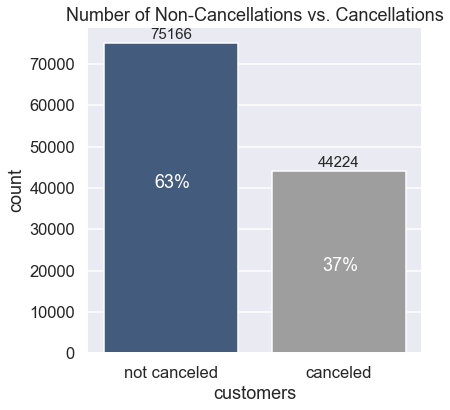

In [216]:
#Get the numbers of canceled and not-canceled observations
class_balance = hotels['is_canceled'].value_counts().reset_index()

sns.set_style('darkgrid')
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(6,6))
values = np.array(class_balance['is_canceled']) 
clr = [NEUTRAL if x>44224 else NEG for x in values]
plots = sns.barplot(data = class_balance, 
                    x='index',
                    y='is_canceled',
                    palette=clr)
ax.set_xticklabels(['not canceled','canceled'])
ax.set_xlabel('customers')
ax.set_ylabel('count')
ax.set_title('Number of Non-Cancellations vs. Cancellations')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(0, 8),
                       textcoords='offset points')
plt.text(-.1,40000,'63%', color=WHITE)
plt.text(.9, 20000, '37%', color=WHITE);

There is a class imbalance, with 63% belonging to the negative class (not canceled) and 37% belonging to the positive class (canceled). This imbalance will need to be addressed before any modeling. 

# Data Processing

## Feature Engineering

In [6]:
hotels_engineered = hotels.copy()
hotels_engineered.shape

(119390, 34)

### Reservation Status Date

In [7]:
#Check how many customers canceled their reservation on the same day they 
#made it.
canceled = hotels_engineered[hotels_engineered['is_canceled'] == 1]
canceled[canceled['lead_time'] == 0].shape

(430, 34)

Because these customers did not have a room reserved for any real period of time, their cancellations did not impact the profitability of the hotel. I am going to remove these records from the data.

In [218]:
#Find and drop the observations of customers that canceled on day of 
#reservation.
index_day_of = (hotels_engineered[
    (hotels_engineered['is_canceled']==1)
    &(hotels_engineered['lead_time']==0)]
    .index)
hotels_engineered = hotels_engineered.drop(index_day_of)
hotels_engineered.shape

(118259, 28)

In [9]:
# Change from string to datetime object so that it can be compared with
#arrival date.
hotels_engineered['reservation_status_date'] = pd.to_datetime(
    hotels_engineered['reservation_status_date'])

### Hotel

In [10]:
# Replace the hotel column with city_hotel where 1=city, 0=resort. 
hotels_engineered['city_hotel'] = np.where(
    hotels_engineered['hotel'] == 'City Hotel', 1, 0)
hotels_engineered = hotels_engineered.drop('hotel', axis=1)

### Lead Time

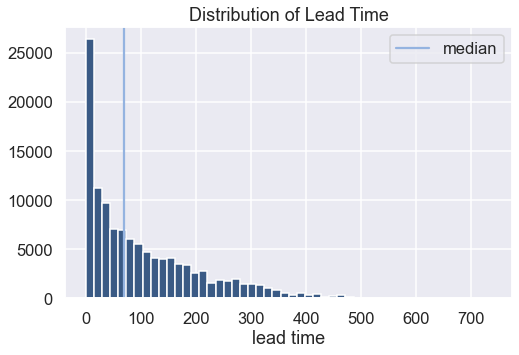

In [11]:
#Examine the distribution of lead time
fig, ax = plt.subplots(figsize=(8,5))
hotels_engineered['lead_time'].hist(bins=50, color=NEUTRAL)
plt.title('Distribution of Lead Time')
ax.set_xlabel('lead time')
plt.axvline(
    hotels_engineered['lead_time'].quantile(0.5), 
    color=POS, 
    label='median'
)
plt.legend();

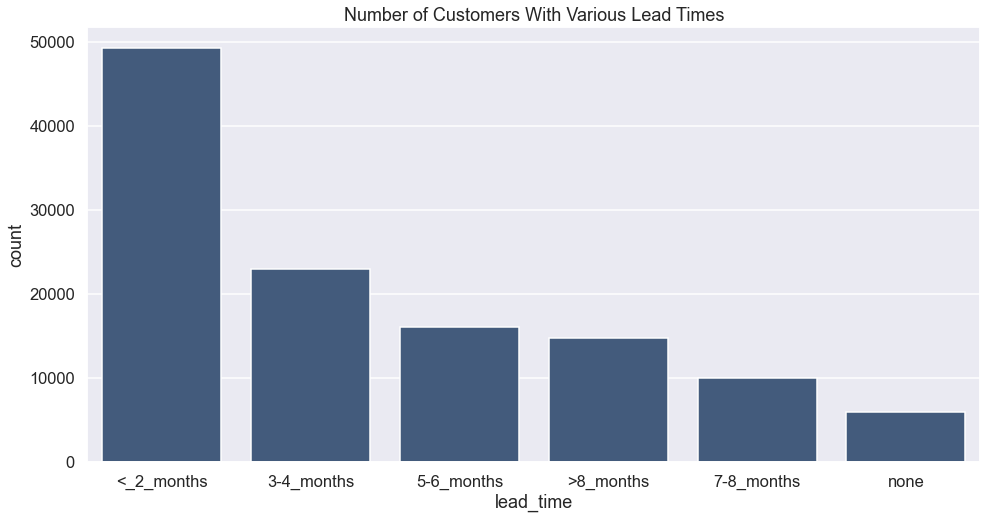

In [12]:
#Because the data is skewed and many of the same values repeat (especially 
#with low lead times), I am going to bin this data into 6 groups to start 
#with.

def lead_time_groups(lead_time):
    """ Takes in the lead time column and groups it into 6 categories"""
    if lead_time == 0:
        return 'none'
    elif lead_time <= 60:
        return '<_2_months'
    elif lead_time <= 120:
        return '3-4_months'
    elif lead_time <= 180:
        return '5-6_months'
    elif lead_time <= 240:
        return '7-8_months'
    else:
        return '>8_months'
    
hotels_engineered['lead_time'] = (
    hotels_engineered['lead_time'].apply(lead_time_groups))

#Visualize the lead time
lead_times = hotels_engineered['lead_time'].value_counts().reset_index()
lead_times.columns = ['lead_time','count']
fig,ax = plt.subplots(figsize=(16,8))
sns.barplot(
    data=lead_times, 
    x='lead_time',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers With Various Lead Times');

### Stay Length

In [13]:
#I am going to combine the weekend and weeknight columns to create a total
#length of stay column.
hotels_engineered['stay_length'] = (
    hotels_engineered['stays_in_weekend_nights'] +
    hotels_engineered['stays_in_week_nights']
)
hotels_engineered = hotels_engineered.drop(['stays_in_weekend_nights',
                                            'stays_in_week_nights'],axis=1)

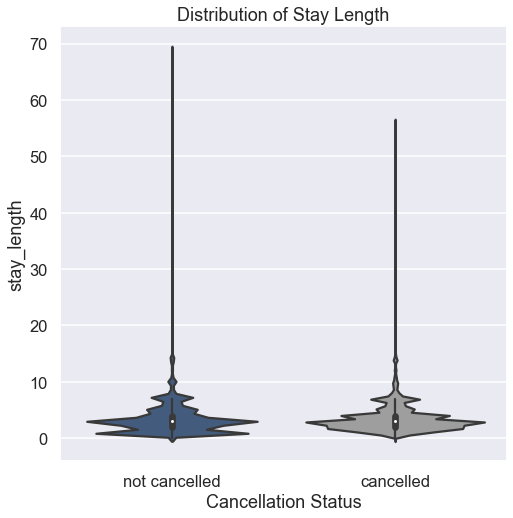

In [14]:
#Examine the distribution of stay length by cancellation status.
fig, ax = plt.subplots(figsize=(8,8))
sns.violinplot(
    data=hotels_engineered, 
    x='is_canceled',
    y='stay_length'
)
plt.xlabel('Cancellation Status')
ax.set_xticklabels(['not cancelled', 'cancelled'])
plt.title('Distribution of Stay Length');

In [15]:
#Check to see the cancellation status of those with 0-night stays.
zero_stay = hotels_engineered[hotels_engineered['stay_length']==0]
zero_stay['is_canceled'].value_counts()

0    680
1     19
Name: is_canceled, dtype: int64

In [16]:
#Check the average daily rate for 0-night stays.
zero_stay['adr'].value_counts()

0.0    699
Name: adr, dtype: int64

Interestingly, there are 680 observations that indicate that a customer checked in and checked out, but had a total stay of 0 nights. This is confirmed by examining the records and noting that in these cases, the reservation date matches the reservation status date, which for customers who did not cancel, is the day they checked out. In looking at the average daily rate for these customers, it is clear that they did not pay for the room, even if they did not technically cancel. 

In [17]:
#Check the count of how many 0-night customers either cancelled their 
#reservation or "checked out" on the day of the reservation.
zero_stay[(
    zero_stay['arrival_date'] == 
    zero_stay['reservation_status_date'])].shape

(699, 33)

Often further examination, none of these customers reserved the room ahead of time. This means that although they did not contribute to any profit for the hotel, they also did not prevent the hotel from earning profit because the room was not held in reserve for them. It is unclear why some of these are coded as cancellations and others are recorded as checked-out. Because this data is ambiguous and the last-minute reservations did not hinder profitability, I am going to drop these records from the data.

In [18]:
hotels_engineered = hotels_engineered[hotels_engineered['stay_length'] != 0]
hotels_engineered.shape

(118261, 33)

For now, I am going to leave stay length as-is, although I may group it into categories later.

### Number of People

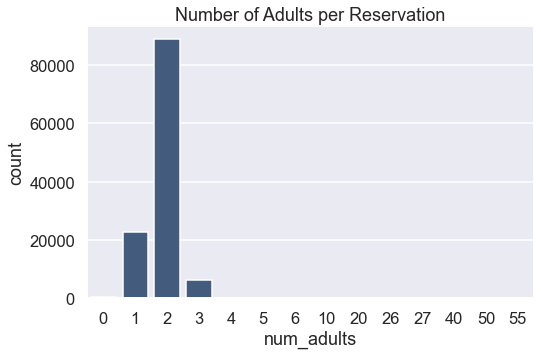

In [19]:
#Examine the number of adults per reservation
adult_counts = hotels_engineered['adults'].value_counts().reset_index()
adult_counts.columns = ['num_adults', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=adult_counts, 
    x='num_adults',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Adults per Reservation');

Most reservations have either 1 or 2 adults, with some having up to 55. I am going to change this column to be categorical with the following string values: 0, 1, 2, 3+. 

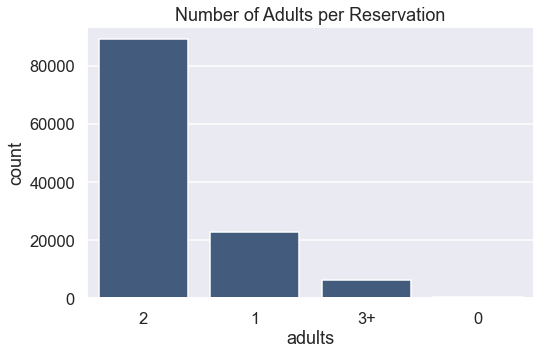

In [20]:
def num_adults(adults):
    """Takes in the adults column and returns a string value of the input if
    it is less than 3 or '3+.'"""
    if adults >= 3:
        return '3+'
    else:
        return str(adults)

hotels_engineered['adults'] = hotels_engineered['adults'].apply(num_adults)
adults = hotels_engineered['adults'].value_counts().reset_index()
adults.columns = ['adults', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=adults, 
    x='adults',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Adults per Reservation');

Currently, children and babies are listed separately and it appears that there may be some data entry errors (10 babies). I am going to combine these into a new column, has_children, with 1 for having at least one non-adult on the reservation and 0 otherwise. 

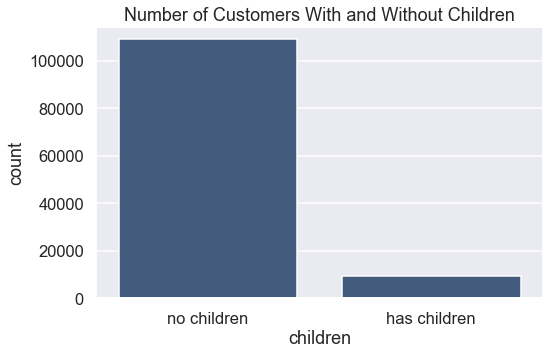

In [21]:
#Add the number of children and babies for each reservation
hotels_engineered['has_children'] = (hotels_engineered['children'] + 
                                     hotels_engineered['babies'])

#Change the column to binary
hotels_engineered['has_children'] =np.where(
    hotels_engineered['has_children'] >0, 1, 0)

hotels_engineered = hotels_engineered.drop(['children','babies'], axis=1)

#Visualize the counts of children
children = hotels_engineered['has_children'].value_counts().reset_index()
children.columns=['children', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=children, 
    x='children',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers With and Without Children')
ax.set_xticklabels(['no children','has children']);


Clearly, the majority of the customers are traveling without children. 

### Country

In [22]:
#Find the number of different countries represented in reservations
hotels_engineered['country'].nunique()

177

In [23]:
#Examine the top ten countries
hotels_engineered['country'].value_counts(normalize=True)[:10]

PRT    0.404535
GBR    0.102706
FRA    0.088181
ESP    0.072526
DEU    0.061812
ITA    0.031912
IRL    0.028635
BEL    0.019823
BRA    0.018813
NLD    0.017828
Name: country, dtype: float64

In [24]:
#Find what percent of reservations come from the top 5 countries
hotels_engineered['country'].value_counts(normalize=True)[:5].sum()

0.7297609345286606

In [25]:
#Find the number of records missing a value for country
hotels_engineered['country'].isnull().sum()

469

There are customers from 177 different countries, but 5 countries make for over 73% of the reservations. There are also 474 missing values. I am going to create 6 categories for this column - one for each of the top 5 countries and group the remaining entries (including the missing values) into 'other.'

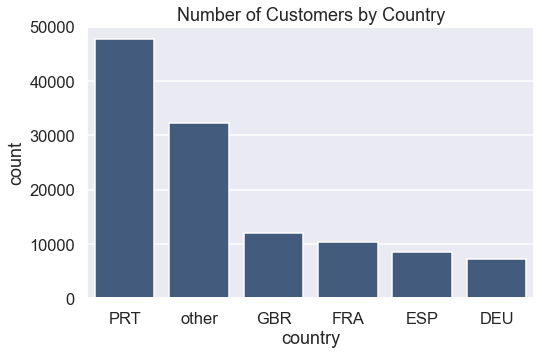

In [26]:
def country_group(country):
    """Takes in the country column, retains the top 5 countries and groups
    everything else into other"""
    top_countries = ['PRT', 'GBR', 'FRA', 'ESP', 'DEU']
    if country in top_countries:
        return country
    else:
        return 'other'

#Visualize the country counts
hotels_engineered['country'] = hotels_engineered['country'].apply(country_group)
country_counts = hotels_engineered['country'].value_counts().reset_index()
country_counts.columns = ['country','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=country_counts, 
    x='country',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers by Country');

### Market Segment and Distribution Channel

In [27]:
#Examine the counts for market segment
hotels_engineered['market_segment'].value_counts(normalize=True)

Online TA        0.473859
Offline TA/TO    0.203085
Groups           0.167147
Direct           0.104033
Corporate        0.044021
Complementary    0.005936
Aviation         0.001903
Undefined        0.000017
Name: market_segment, dtype: float64

In [28]:
#Examine the counts for distribution channel
hotels_engineered['distribution_channel'].value_counts(normalize=True)

TA/TO        0.822088
Direct       0.120851
Corporate    0.055411
GDS          0.001607
Undefined    0.000042
Name: distribution_channel, dtype: float64

It appears that there is some overlap between these features, so it does not make sense to keep both of them. Because groups account for 16% of the reservations and is only defined in the market segment column, I will work with that column and drop the other.

It would be interesting to distinguish between online and offline reservations, but since that information is only available for reservations through travel agents, I will not include it.

I will create 5 major groupings for market segment: TA/TO (travel agent/ tour operator), groups, direct, corporate and other. 

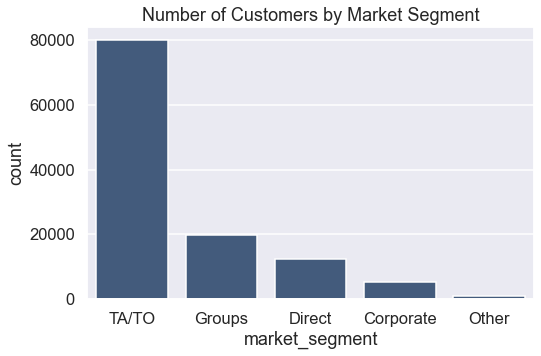

In [29]:
def market_group(market):
    """Takes in market column, combines TA and TO into a single class,
    maintains groups, direct and corporate and groups everything else as
    other."""
    if market == 'Online TA' or market == 'Offline TA/TO':
        return 'TA/TO'
    elif market in ['Groups', 'Direct', 'Corporate']:
        return market
    else:
        return 'Other'
    
hotels_engineered['market_segment'] = (hotels_engineered['market_segment'].
                                       apply(market_group))
hotels_engineered = hotels_engineered.drop('distribution_channel', axis=1)

#Visualize the market segments
segments = hotels_engineered['market_segment'].value_counts().reset_index()
segments.columns=['market_segment','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=segments, 
    x='market_segment',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers by Market Segment');

### Prior Customer Behavior

There are three columns that address prior customer behavior: is_repeated_guest, previous_cancellations and previous_bookings_not_canceled. The last column does not contain any additional information, so will be dropped. The other two are already encoded with 0 and 1.

In [30]:
#Drop the unneeded column
hotels_engineered = hotels_engineered.drop('previous_bookings_not_canceled',
                                           axis=1)

### Room Type

There are two columns that deal with room type - the reservation and the assigned room type. I am going to keep the reservation column and remove the assigned column, since that information would not be known unless the customer does not cancel. 

In [31]:
#Drop the unneeded column
hotels_engineered = hotels_engineered.drop('assigned_room_type', axis=1)

In [32]:
#Examine the counts of room type
hotels_engineered['reserved_room_type'].value_counts(normalize=True)

A    0.720128
D    0.161118
E    0.054777
F    0.024277
G    0.017453
B    0.009411
C    0.007779
H    0.005023
L    0.000034
Name: reserved_room_type, dtype: float64

In [33]:
#Examine the average daily rate for each room type
hotels_engineered.groupby('reserved_room_type')['adr'].mean()

reserved_room_type
A     91.386957
B     90.766379
C    161.804402
D    121.241655
E    125.351304
F    168.574267
G    177.796308
H    189.693754
L    151.000000
Name: adr, dtype: float64

There are ten room types that each appear in both hotels, with A and D accounting for 88% of the reservations. Based on the average price of A and D as well as the frequency, it appears that A is a standard room and D is a premium room. Based on the average prices, I am going to classify A and B as standard rooms, D,E and L as premium and the rest as super_premium. 

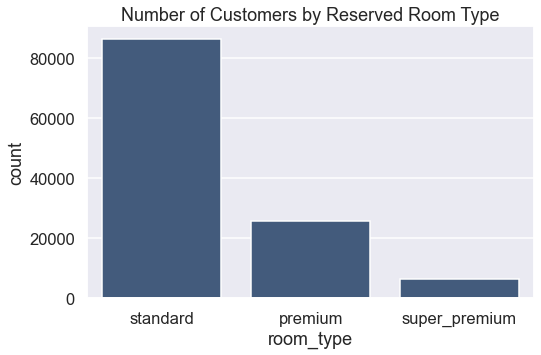

In [34]:
def room_type(room):
    """Takes in the room type column and classifies A and B as standard, D,E,
    L as premium and the rest as super-premium."""
    if room in ['A','B']:
        return 'standard'
    elif room in ['D','E','L']:
        return 'premium'
    else:
        return 'super_premium'
    
hotels_engineered['reserved_room_type'] = (
    hotels_engineered['reserved_room_type'].apply(room_type))

#Visualize the room types
room_types = (
    hotels_engineered['reserved_room_type'].
    value_counts().
    reset_index()
)
room_types.columns = ['room_type','count']
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=room_types, 
    x='room_type',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers by Reserved Room Type');

### Booking Details

In [35]:
#Examine the number of booking changes made per reservation
hotels_engineered['booking_changes'].value_counts()

0     100346
1      12578
2       3780
3        923
4        373
5        114
6         62
7         30
8         17
9          8
10         6
13         5
14         5
15         3
11         2
12         2
16         2
17         2
20         1
18         1
21         1
Name: booking_changes, dtype: int64

The majority of customers did not make any changes and of those that did, the most common was a single change. I am going to change this to a binary column: 1 for made changes and 0 for no changes.

In [36]:
#Make booking changes a binary column
hotels_engineered['booking_changes'] = (
    np.where(
        hotels_engineered['booking_changes']==0, 0, 1)
)

In [37]:
#Examine the deposit types
hotels_engineered['deposit_type'].value_counts()

No Deposit    103530
Non Refund     14569
Refundable       162
Name: deposit_type, dtype: int64

I am going to make a similar adjustment to deposit type since there are so few refundable deposits. The column will be changed to deposit_made with 1 for yes and 0 for no. 

In [38]:
#Change the name of the deposit column
hotels_engineered = hotels_engineered.rename(
    columns={'deposit_type': 'deposit_made'})

def deposit_made(deposit):
    """Takes in the deposit column and returns 0 for no deposit and 1 for
    a deposit of either type."""
    if deposit == 'No Deposit':
        return 0
    else:
        return 1
    
hotels_engineered['deposit_made'] = (
    hotels_engineered['deposit_made'].apply(deposit_made))


In [39]:
#Examine the days each customer was on a waiting list
hotels_engineered['days_in_waiting_list'].value_counts()

0      114564
39        227
58        164
44        141
31        127
        ...  
175         1
117         1
89          1
92          1
183         1
Name: days_in_waiting_list, Length: 128, dtype: int64

Days in waiting list follows a similar pattern. I am going to replace the column with waiting_list with 1 for a wait and 0 for no wait. 

In [40]:
#Rename the waiting list column
hotels_engineered = hotels_engineered.rename(
    columns={'days_in_waiting_list': 'waiting_list'})

#Change the column to binary
hotels_engineered['waiting_list'] = (
    np.where(hotels_engineered['waiting_list']==0, 0, 1))

### Booking Agent and Company

In [41]:
#Examine the agent column
hotels_engineered['agent'].value_counts(normalize=True)[:10]

9.0      0.310888
240.0    0.134338
1.0      0.070227
14.0     0.035285
7.0      0.034376
6.0      0.031454
250.0    0.027761
241.0    0.016631
28.0     0.015976
8.0      0.014647
3.0      0.013045
37.0     0.011990
19.0     0.010358
40.0     0.010113
314.0    0.008902
21.0     0.008550
229.0    0.007671
242.0    0.007465
83.0     0.006772
29.0     0.006674
171.0    0.005873
12.0     0.005638
85.0     0.005374
20.0     0.005277
96.0     0.005247
243.0    0.005003
30.0     0.004729
134.0    0.004681
298.0    0.004612
27.0     0.004368
15.0     0.003899
26.0     0.003869
11.0     0.003850
22.0     0.003713
56.0     0.003664
273.0    0.003391
177.0    0.003361
86.0     0.003283
58.0     0.003273
5.0      0.003205
119.0    0.002971
196.0    0.002902
34.0     0.002873
44.0     0.002843
138.0    0.002795
315.0    0.002756
38.0     0.002677
10.0     0.002521
Name: agent, dtype: float64

In [42]:
#Find the number of missing values
hotels_engineered['agent'].isna().sum()

15922

There are 3 agents that account for around 50% of the bookings and the rest are made by agents that have small numbers of bookings. There are also 16,115 records with no value for agent. I am going to keep the top 3 agents, replace the missing values with 'none' and group the rest into 'other.'

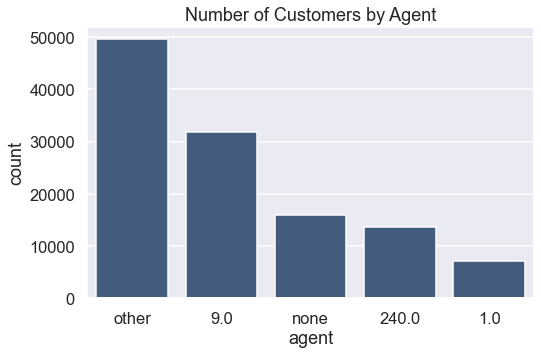

In [43]:
def get_agent(agent):
    """Takes in the agent column and returns a string value of the input for
    the top three agents, group the remaining agents into other and replace
    missing values with none. """
    if agent in [9.0, 240.0, 1.0]:
        return str(agent)
    elif np.isnan(agent):
        return 'none'
    else:
        return 'other'
    
hotels_engineered['agent'] = hotels_engineered['agent'].apply(get_agent)     
agent_count = hotels_engineered['agent'].value_counts().reset_index()
agent_count.columns = ['agent','count']

#Visualize the agents
fig,ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=agent_count, 
    x='agent',
    y='count', 
    color=NEUTRAL
)
plt.title('Number of Customers by Agent');

In [44]:
#Examine the company counts
hotels_engineered['company'].value_counts(normalize=True)

40.0     0.137387
223.0    0.116066
67.0     0.040090
45.0     0.035285
153.0    0.030480
           ...   
373.0    0.000150
499.0    0.000150
347.0    0.000150
140.0    0.000150
461.0    0.000150
Name: company, Length: 349, dtype: float64

In [45]:
#Find the number of missing values
hotels_engineered['company'].isna().sum()

111601

There are so many missing values in this column and no single company accounts for more than 13% of the bookings, that I am going to drop this column.

In [46]:
#Drop the company column
hotels_engineered = hotels_engineered.drop('company', axis=1)

### Average Daily Rate

In [47]:
#Examine the statstics for the average daily rate column
hotels_engineered['adr'].describe()

count    118261.000000
mean        102.477275
std          50.019486
min          -6.380000
25%          70.000000
50%          95.000000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

In [48]:
#Examinethe outliers of negative room rates and rates over 1,000
hotels_engineered[((hotels_engineered['adr'] < 0) 
                   | (hotels_engineered['adr'] > 1000))]

,arrival_date,is_canceled,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,city_hotel,stay_length,has_children
14969,2017-03-05,0,7-8_months,10,2,BB,GBR,Groups,1,0,...,0,Check-Out,2017-03-15,Chase Santos,Chase_Santos@outlook.com,472-408-0661,************9176,0,10,0
48515,2016-03-25,1,<_2_months,13,2,BB,PRT,TA/TO,0,0,...,0,Canceled,2016-02-19,Daniel Walter,DanielWalter27@comcast.net,865-280-5832,************6075,1,1,0


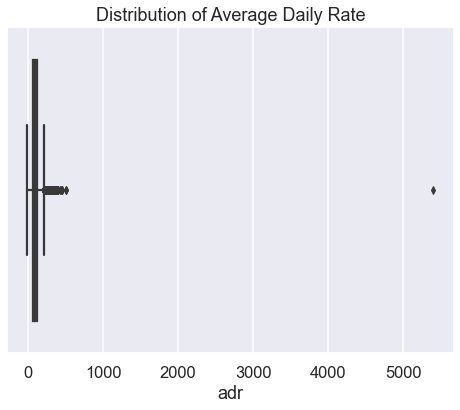

In [49]:
#Examine the distribution of average daily rate
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(
    data=hotels_engineered, 
    x='adr'
)
plt.title('Distribution of Average Daily Rate');

There is clearly an outlier in this column. Whereas the median daily rate is 95, the maximum is 5,400. Additionally, there is one record with an average daily rate below 0. I am going to remove these two records. 

In [50]:
#Remove the two observations with outliers
hotels_engineered = hotels_engineered[((hotels_engineered['adr'] >= 0) 
                   & (hotels_engineered['adr'] < 1000))]

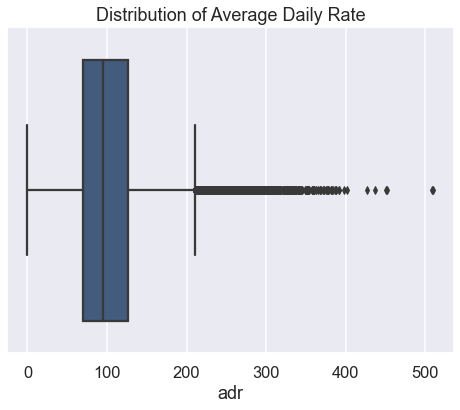

In [51]:
#Examine the distribution after the removal of outliers
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(
    data=hotels_engineered, 
    x='adr'
)
plt.title('Distribution of Average Daily Rate');

### Special Requests

In [52]:
#Examine the special requests counts
hotels_engineered['total_of_special_requests'].value_counts()

0    69535
1    32982
2    12879
3     2483
4      340
5       40
Name: total_of_special_requests, dtype: int64

Because the number of special requests rapidly drops off after 2, I am going to group these as: 0, 1, 2 and 3+.

In [53]:
def get_requests(request):
    """Takes in the special request column and returns a string of the input
    for values less than or equal 2 or returns 3+"""
    if request in [0,1,2]:
        return str(request)
    else:
        return '3+'

hotels_engineered['total_of_special_requests'] = (
    hotels_engineered['total_of_special_requests'].apply(get_requests))

## Observations Removed

A total of 1,131 observations were removed. This is about 0.95% of the data.

## Feature Selection

In [54]:
hotels_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118259 entries, 2 to 119389
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   arrival_date                 118259 non-null  datetime64[ns]
 1   is_canceled                  118259 non-null  int64         
 2   lead_time                    118259 non-null  object        
 3   arrival_date_week_number     118259 non-null  int64         
 4   adults                       118259 non-null  object        
 5   meal                         118259 non-null  object        
 6   country                      118259 non-null  object        
 7   market_segment               118259 non-null  object        
 8   is_repeated_guest            118259 non-null  int64         
 9   previous_cancellations       118259 non-null  int64         
 10  reserved_room_type           118259 non-null  object        
 11  booking_changes           

The columns with name, phone, email and credit card have synthetic data for anonymity and so can be removed. 

The columns of reservation status and reservation status date will need to be removed for modeling since I am using 'is_canceled' as the target and those two columns contain information that relates to the target. 

I am also going to remove:
arrival date (too granular, and keeping arrival week number to account for seasonal changes),
meal (not enough variation or relevant information),
required_car_parking_spaces (not enough variation or relevant information)


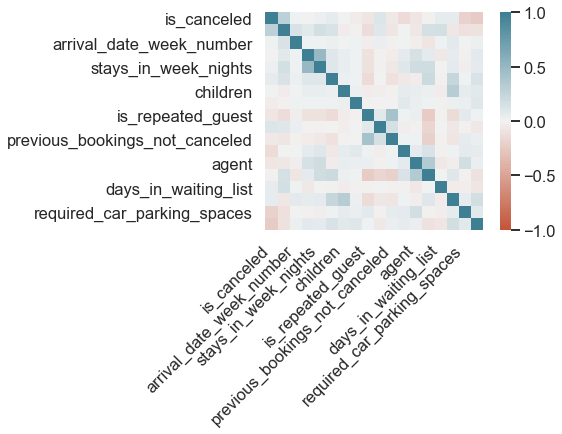

In [55]:
#Checking correlations with features
corr = hotels.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Other than arrival date week number, the other features do not have an obviously strong association with cancellation status. Because of this, I will leave in the majority of features and later remove the ones that the model suggests are unimportant. 

In [56]:
#Features to keep
target_features = ['is_canceled', 'lead_time', 'arrival_date_week_number',
       'adults', 'country', 'market_segment', 'is_repeated_guest',
       'previous_cancellations', 'reserved_room_type', 'booking_changes',
       'deposit_made', 'agent', 'waiting_list', 'customer_type', 'adr',
       'total_of_special_requests','city_hotel', 'stay_length',
       'has_children']

#Create a dataframe with engineered and selected features
hotels_cleaned = hotels_engineered.copy()
hotels_cleaned = hotels_cleaned[target_features]
hotels_cleaned.head()

,is_canceled,lead_time,arrival_date_week_number,adults,country,market_segment,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_made,agent,waiting_list,customer_type,adr,total_of_special_requests,city_hotel,stay_length,has_children
2,0,<_2_months,27,1,GBR,Direct,0,0,standard,0,0,none,0,Transient,75.0,0,0,1,0
3,0,<_2_months,27,1,GBR,Corporate,0,0,standard,0,0,other,0,Transient,75.0,0,0,1,0
4,0,<_2_months,27,2,GBR,TA/TO,0,0,standard,0,0,240.0,0,Transient,98.0,1,0,2,0
5,0,<_2_months,27,2,GBR,TA/TO,0,0,standard,0,0,240.0,0,Transient,98.0,1,0,2,0
6,0,none,27,2,PRT,Direct,0,0,super_premium,0,0,none,0,Transient,107.0,0,0,2,0


# Modeling

## Goals for Modeling

The goal is to create a model that can be used by the hotels to predict which customers are likely to cancel their reservations. 

If this information is used to implement policy changes that may negatively impact customers that are falsely identified as potentially canceling (i.e. requiring a deposit or overbooking rooms), it is important to have high precision. However, if the goal is to identify as many potential cancellations as possible and the policy changes don't negatively impact customers falsely identified as cancellations (i.e. sending a reminder email or offering last-minute specials during times when cancellations are more likely to occur), it is important to have high recall.

Since this situation has arguments for both high precision and recall and there are no catastrophic consequences foreseen for either false positives or false negatives, it makes the most sense to select a model that balances precision and recall and has a high overall accuracy. Therefore, since the F1 score is a measure of both precision and recall, I will be optimizing for F1 when evaluating the models. 

## Data Preparation

In [240]:
#Split the data into train, validation and test sets.
y = hotels_cleaned['is_canceled']
X = hotels_cleaned.drop('is_canceled', axis=1)

X_train, X_, y_train, y_ = train_test_split(X,
                                           y,
                                           stratify=y, 
                                           random_state=SEED,
                                           test_size=.30)
X_val, X_test, y_val, y_test = train_test_split(X_,
                                                y_,
                                                stratify=y_, 
                                                random_state=SEED,
                                                test_size=.5)
#Verify the shapes of the data
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape,y_test.shape)

((82781,), (17739,), (17739,))

In [58]:
#Identify categorical and numeric columns in X_train.
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes('number').columns

#One hot encode the categorical features and scale the numeric features.
num_transformer = Pipeline([('scale', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', 
                                                  sparse=False))])


transformer = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ])

#Create and apply a pipeline to preprocess the data
preprocess = Pipeline([('transformer', transformer)])

X_train_processed = preprocess.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed)

X_val_processed = preprocess.transform(X_val)

cat_names = (preprocess.named_steps['transformer']
             .transformers_[1][1].named_steps['ohe']
             .get_feature_names(cat_cols))
feature_names = list(num_cols) + list(cat_names)

In [59]:
#Indicies for categorical variables.
i_1 = len(num_cols)+1
i_2 = len(feature_names)

#Perform oversampling on the training set to create balanced classes. 
oversampler = SMOTENC(categorical_features = list(range(i_1,i_2)), 
                      n_jobs=-2, 
                      random_state=SEED)


In [60]:
#Check to see if the SMOTE files exist and if they do not, use SMOTE to
#oversample the training data.
if ('X_smote.pk1' in os.listdir('files') 
    and 'y_smote.pk1' in os.listdir('files')):
    
    X_train_smote = joblib.load('files/X_smote.pk1')
    y_train_smote = joblib.load('files/y_smote.pk1')
    
else: 
    X_train_smote, y_train_smote = oversampler.fit_resample(X_train_processed, 
                                                           y_train)
    joblib.dump(X_train_smote, 'files/X_smote.pk1')
    joblib.dump(y_train_smote, 'files/y_smote.pk1')
    
X_train_smote.shape, y_train_smote.shape

((104278, 47), (104278,))

## Model Training and Evaluation Functions and Dictionaries

In [61]:
#A dictionary with the basic classification algorithms. 
clf_dict = {
           'baseline': DummyClassifier(
                random_state=SEED, 
                strategy='stratified'),
           'log_r': LogisticRegression(
               class_weight='balanced', 
               max_iter=2000),
           'knn': KNeighborsClassifier(
               n_jobs=-2),
           'svc': SVC(random_state=SEED,
                     class_weight='balanced'),
           'tree': DecisionTreeClassifier(
               random_state=SEED,
               class_weight='balanced'),
           'forest': RandomForestClassifier(
               random_state=SEED,
               n_jobs=-2,
               class_weight='balanced'),
           'GB_clf': GradientBoostingClassifier(random_state=SEED),
           'ada': AdaBoostClassifier(random_state=SEED),
           'xgb': xgb.XGBClassifier(random_state=SEED)
           }

# A dictionary with the scoring methods for model evaluation.
scoring = {'AUC': 'roc_auc',
          'Accuracy': make_scorer(accuracy_score),
          'Recall': make_scorer(recall_score),
          'Precision': make_scorer(precision_score),
          'F1': make_scorer(f1_score)}

In [62]:
screen_dict = {}

def screen_model(clf, clf_dict, scoring, X, y):
    """Takes in the classifier key from the classifier dictionary, the
    classifier dictionary, a scoring dictionary and an X and y and runs
    a 5-fold cross_validation. The scores are reported and added to a 
    dictionary."""
    
    clf_screen = {}

    score = cross_validate(clf_dict[clf],
                    X,
                    y,
                    scoring=scoring,
                    cv=5,
                    return_train_score=True,
                    n_jobs=-2)

    for k,v in score.items():
        clf_screen[f'{k} mean'] = v.mean()
        clf_screen[f'{k} std'] = v.std()
        
    screen_dict[clf] = clf_screen
    return screen_dict[clf]


In [63]:
report_dict = {}

def get_pred(clf, clf_dict, X_train, y_train, X_val, y_val):
    """Takes in a classifier, the classifier dictionary, the train and
    validation sets and returns the predicted y values on the validation
    set."""
    clf = clf_dict[clf]
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return y_val_pred
    
def get_report(clf, clf_dict, X_train, y_train, X_val, y_val):  
    """Takes in a classifier, the classifier dictionary, the train and
    validation sets and returns the classifation report for the validation 
    set."""
    y_val_pred = get_pred(clf, clf_dict, X_train, y_train, X_val, y_val)
    report = classification_report(y_val, y_val_pred, output_dict=True)
    report_dict[clf] = report
    report = pd.DataFrame(report).T
    return report

## Initial Model Selection

### Baseline Model

In [224]:
baseline = screen_model('baseline', clf_dict, scoring, X_train, y_train)
screen_dict['baseline'] = baseline
screen_dict['baseline']

{'fit_time mean': 0.023159599304199217,
 'fit_time std': 0.0008162414376750109,
 'score_time mean': 0.023169898986816408,
 'score_time std': 0.002487321269998946,
 'test_AUC mean': 0.5010478217070143,
 'test_AUC std': 0.004293257854723379,
 'train_AUC mean': 0.5008432975626657,
 'train_AUC std': 0.0007988946471776544,
 'test_Accuracy mean': 0.5353039438257052,
 'test_Accuracy std': 0.0040061404779628,
 'train_Accuracy mean': 0.5346818692197732,
 'train_Accuracy std': 0.0007446780107579652,
 'test_Recall mean': 0.36913378783483225,
 'test_Recall std': 0.00539792631737305,
 'train_Recall mean': 0.3705371702193002,
 'train_Recall std': 0.0010085920572964714,
 'test_Precision mean': 0.37148589841812785,
 'test_Precision std': 0.00544357992174424,
 'train_Precision mean': 0.37122164816351616,
 'train_Precision std': 0.0010074026790662242,
 'test_F1 mean': 0.3703061057456212,
 'test_F1 std': 0.0054205839488806395,
 'train_F1 mean': 0.3708790933563734,
 'train_F1 std': 0.0010079959434384736}

In [65]:
baseline_report = get_report('baseline', 
           clf_dict, 
           X_train, 
           y_train, 
           X_val, 
           y_val)
baseline_report

,precision,recall,f1-score,support
0,0.627531,0.629553,0.628541,11173.000000
1,0.366156,0.364149,0.365150,6566.000000
accuracy,0.531315,0.531315,0.531315,0.531315
macro avg,0.496844,0.496851,0.496845,17739.000000
weighted avg,0.530785,0.531315,0.531048,17739.000000


### Logistic Regression

In [66]:
log_r_file = 'files/log_r.pk1'
if 'log_r.pk1' in os.listdir('files'):
    log_r = joblib.load(log_r_file)
else:
    log_r = screen_model('log_r', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(log_r, log_r_file)
screen_dict['log_r'] = log_r
screen_dict['log_r']

{'fit_time mean': 6.9473072528839115,
 'fit_time std': 0.4931527904123124,
 'score_time mean': 0.03181619644165039,
 'score_time std': 0.00611498208318512,
 'test_AUC mean': 0.9024616789881168,
 'test_AUC std': 0.010745930983040976,
 'train_AUC mean': 0.9032914345856116,
 'train_AUC std': 0.002761062831490229,
 'test_Accuracy mean': 0.8084354439392237,
 'test_Accuracy std': 0.012891203184716593,
 'train_Accuracy mean': 0.8092263159497906,
 'train_Accuracy std': 0.0029686509578963497,
 'test_Recall mean': 0.7903879581604645,
 'test_Recall std': 0.03022759961838225,
 'train_Recall mean': 0.791830509484054,
 'train_Recall std': 0.0034569839813973066,
 'test_Precision mean': 0.8199256928968646,
 'test_Precision std': 0.00258433961540219,
 'train_Precision mean': 0.8203698422241251,
 'train_Precision std': 0.0027551987450301573,
 'test_F1 mean': 0.804624900866042,
 'test_F1 std': 0.016452602637353084,
 'train_F1 mean': 0.8058473549972046,
 'train_F1 std': 0.003117835507872396}

In [67]:
log_r_report = get_report('log_r', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)
log_r_report

,precision,recall,f1-score,support
0,0.862549,0.832364,0.847187,11173.000000
1,0.730775,0.774292,0.751904,6566.000000
accuracy,0.810869,0.810869,0.810869,0.810869
macro avg,0.796662,0.803328,0.799546,17739.000000
weighted avg,0.813773,0.810869,0.811919,17739.000000


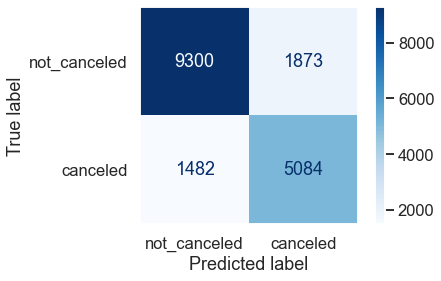

In [68]:
log_r_matrix = plot_confusion_matrix(clf_dict['log_r'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None);
log_r_matrix

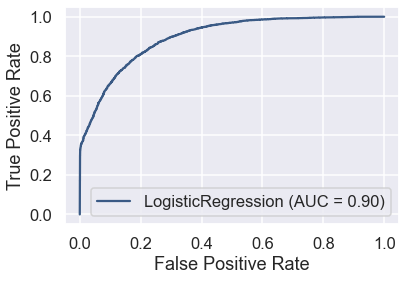

In [69]:
log_r_roc = plot_roc_curve(clf_dict['log_r'],X_val_processed, y_val);
log_r_roc

#### Preliminary Evaluation

Pros:
- consistency between train and test sets with cross-validation implies little overfitting

Cons:
- it does better with both precision and recall at predicting the negative class (those that don't cancel) than the positive class (those that do cancel); very low precision and recall on the positive class
- the accuracy is only around 81%
- precision for the positive class is quite low

Evaluate further: No

Tuning goals:
- increase C value to make the model more complex to try to improve accuracy and precision/recall for the positive class

### K-Nearest Neighbors

In [70]:
knn_file = 'files/knn.pk1'
if 'knn.pk1' in os.listdir('files'):
    knn = joblib.load(knn_file)
else:
    knn = screen_model('knn', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(knn, knn_file)
screen_dict['knn'] = knn
screen_dict['knn']

{'fit_time mean': 59.025218391418456,
 'fit_time std': 0.6654670403181209,
 'score_time mean': 112.04372224807739,
 'score_time std': 4.7544357622120135,
 'test_AUC mean': 0.928730672134946,
 'test_AUC std': 0.015485259763383634,
 'train_AUC mean': 0.9718378312800962,
 'train_AUC std': 0.0029563150869015486,
 'test_Accuracy mean': 0.8556938270964596,
 'test_Accuracy std': 0.01678254191765501,
 'train_Accuracy mean': 0.9011584676553296,
 'train_Accuracy std': 0.004421607249674015,
 'test_Recall mean': 0.8864006500488225,
 'test_Recall std': 0.03580856643295367,
 'train_Recall mean': 0.9219442782154814,
 'train_Recall std': 0.009339250701773771,
 'test_Precision mean': 0.8349955602305528,
 'test_Precision std': 0.004673054004338359,
 'train_Precision mean': 0.885141945257109,
 'train_Precision std': 0.0007820843669079443,
 'test_F1 mean': 0.8596499872603867,
 'test_F1 std': 0.01871091686405955,
 'train_F1 mean': 0.9031480454237913,
 'train_F1 std': 0.004805931132864943}

In [71]:
knn_report = get_report('knn', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

knn_report

,precision,recall,f1-score,support
0,0.886972,0.832990,0.859134,11173.00000
1,0.742479,0.819373,0.779033,6566.00000
accuracy,0.827950,0.827950,0.827950,0.82795
macro avg,0.814725,0.826181,0.819083,17739.00000
weighted avg,0.833489,0.827950,0.829485,17739.00000


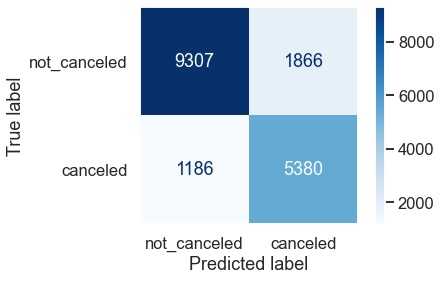

In [72]:
knn_matrix = plot_confusion_matrix(clf_dict['knn'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None);
knn_matrix

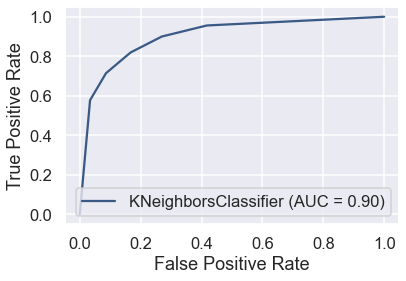

In [73]:
knn_roc = plot_roc_curve(clf_dict['knn'],X_val_processed, y_val);
knn_roc

   #### Preliminary Evaluation

Pros:
- precision is good for negative class

Cons:
- differences in train and test results imply overfitting
- very low precision for the positive class

Evaluate further: No

Tuning goals:
- increase k to reduce overfitting

### Support Vector Classifier

In [74]:
svc_file = 'files/svc.pk1'
if 'svc.pk1' in os.listdir('files'):
    svc = joblib.load(svc_file)
else:
    svc = screen_model('svc', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(svc, svc_file)
screen_dict['svc'] = svc
screen_dict['svc']

{'fit_time mean': 475.2095597267151,
 'fit_time std': 50.71884288691242,
 'score_time mean': 82.05917277336121,
 'score_time std': 0.7014935591041641,
 'test_AUC mean': 0.9273608421457302,
 'test_AUC std': 0.008360796142282396,
 'train_AUC mean': 0.9336532299080632,
 'train_AUC std': 0.0024175524001753997,
 'test_Accuracy mean': 0.8447996826683448,
 'test_Accuracy std': 0.008763161229033992,
 'train_Accuracy mean': 0.8516034265865994,
 'train_Accuracy std': 0.003538578768948049,
 'test_Recall mean': 0.8272891142389511,
 'test_Recall std': 0.022038218370018275,
 'train_Recall mean': 0.8355118253142984,
 'train_Recall std': 0.004568537827624795,
 'test_Precision mean': 0.8573342987578277,
 'test_Precision std': 0.0009528709781184397,
 'train_Precision mean': 0.8632930801565241,
 'train_Precision std': 0.003198859742708894,
 'test_F1 mean': 0.8418850707098123,
 'test_F1 std': 0.010998640748809435,
 'train_F1 mean': 0.8491730227595722,
 'train_F1 std': 0.003729174271397226}

In [75]:
svc_report_file = 'files/svc_report.pk1'
if 'svc_report.pk1' in os.listdir('files'):
    svc_report = joblib.load(svc_report_file)
else:
    svc_report = get_report('svc', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)
svc_report

,precision,recall,f1-score,support
0,0.888400,0.867090,0.877616,11173.00000
1,0.782704,0.814651,0.798358,6566.00000
accuracy,0.847680,0.847680,0.847680,0.84768
macro avg,0.835552,0.840871,0.837987,17739.00000
weighted avg,0.849277,0.847680,0.848279,17739.00000


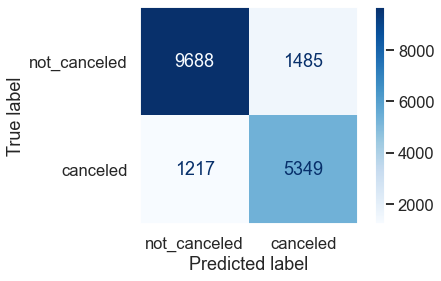

In [76]:
clf_dict['svc'].fit(X_train_smote, y_train_smote)

svc_matrix = plot_confusion_matrix(clf_dict['svc'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
svc_matrix

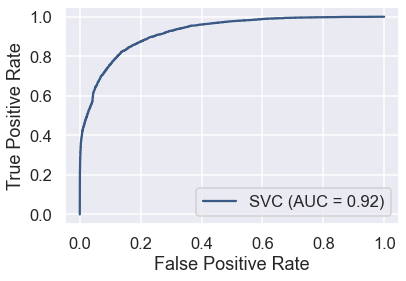

In [77]:
svc_roc = plot_roc_curve(clf_dict['svc'],X_val_processed, y_val);
svc_roc

#### Preliminary Evaluation

Pros:
- consistent performance across folds
- does not appear to be overfitting
- balanced precision and recall scores

Cons:
- better at predicting the negative class than the positive class

Evaluate further: Yes

Tuning goals:
- try linear kernel
- increase C to improve accuracy (since there is little sign of overfitting currently)
- increase gamma to increase complexity


### Decision Tree

In [78]:
tree_file = 'files/tree.pk1'
if 'tree.pk1' in os.listdir('files'):
    tree = joblib.load(tree_file)
else:
    tree = screen_model('tree', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(tree, tree_file)
screen_dict['tree'] = tree
screen_dict['tree']

{'fit_time mean': 0.9664841651916504,
 'fit_time std': 0.01528410377977979,
 'score_time mean': 0.036895751953125,
 'score_time std': 0.0036647541832060464,
 'test_AUC mean': 0.8526853956512361,
 'test_AUC std': 0.02271078122505489,
 'train_AUC mean': 0.9998907539245738,
 'train_AUC std': 2.621266575091862e-05,
 'test_Accuracy mean': 0.8496236392862585,
 'test_Accuracy std': 0.022114812953944997,
 'train_Accuracy mean': 0.993174500220597,
 'train_Accuracy std': 0.00087846780077875,
 'test_Recall mean': 0.849000985498795,
 'test_Recall std': 0.053371359592713434,
 'train_Recall mean': 0.9917000868038433,
 'train_Recall std': 0.0023778441829099177,
 'test_Precision mean': 0.8500598262934755,
 'test_Precision std': 0.0027542790521181263,
 'train_Precision mean': 0.9946489282376652,
 'train_Precision std': 0.003092157407576091,
 'test_F1 mean': 0.8487027002447611,
 'test_F1 std': 0.026523775134647154,
 'train_F1 mean': 0.9931654135746232,
 'train_F1 std': 0.0008714969474552682}

In [79]:
tree_report = get_report('tree', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

tree_report

,precision,recall,f1-score,support
0,0.873470,0.862526,0.867964,11173.000000
1,0.770951,0.787390,0.779084,6566.000000
accuracy,0.834714,0.834714,0.834714,0.834714
macro avg,0.822211,0.824958,0.823524,17739.000000
weighted avg,0.835524,0.834714,0.835065,17739.000000


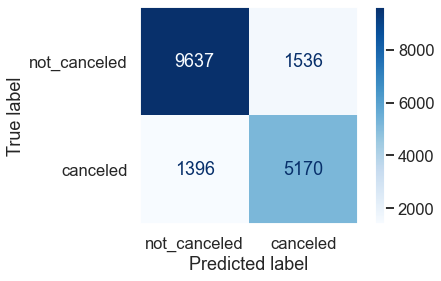

In [80]:
tree_matrix = plot_confusion_matrix(clf_dict['tree'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
tree_matrix

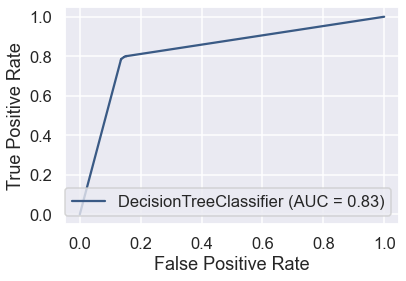

In [81]:
tree_roc = plot_roc_curve(clf_dict['tree'],X_val_processed, y_val);
tree_roc

#### Preliminary Evaluation

Pros:
- performs well on training data
- precision and recall are balanced

Cons:
- badly overfitting

Evaluate further: No

Tuning goals:
- use a random forest to reduce overfitting

### Random Forest

In [82]:
forest_file = 'files/forest.pk1'
if 'forest.pk1' in os.listdir('files'):
    forest = joblib.load(forest_file)
else:
    forest = screen_model('forest', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(forest, forest_file)
screen_dict['forest'] = forest
screen_dict['forest']

{'fit_time mean': 9.763059997558594,
 'fit_time std': 0.6121361766582489,
 'score_time mean': 0.45316901206970217,
 'score_time std': 0.07085964609182009,
 'test_AUC mean': 0.958018012839819,
 'test_AUC std': 0.014914826433504419,
 'train_AUC mean': 0.9994975518532909,
 'train_AUC std': 6.159525607791054e-05,
 'test_Accuracy mean': 0.8845687582727543,
 'test_Accuracy std': 0.024924455668264723,
 'train_Accuracy mean': 0.993169705351107,
 'train_Accuracy std': 0.0008789190613168239,
 'test_Recall mean': 0.8826804187691148,
 'test_Recall std': 0.059828514455909074,
 'train_Recall mean': 0.9934597939920808,
 'train_Recall std': 0.0007681056509052539,
 'test_Precision mean': 0.886167375963069,
 'test_Precision std': 0.0021629655269323417,
 'train_Precision mean': 0.992884078785534,
 'train_Precision std': 0.0010250399367002514,
 'test_F1 mean': 0.883348812255447,
 'test_F1 std': 0.028645798222837398,
 'train_F1 mean': 0.9931718024584925,
 'train_F1 std': 0.0008777108105875681}

In [83]:
forest_report = get_report('forest', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

forest_report

,precision,recall,f1-score,support
0,0.888591,0.890898,0.889743,11173.000000
1,0.813523,0.809930,0.811723,6566.000000
accuracy,0.860928,0.860928,0.860928,0.860928
macro avg,0.851057,0.850414,0.850733,17739.000000
weighted avg,0.860805,0.860928,0.860864,17739.000000


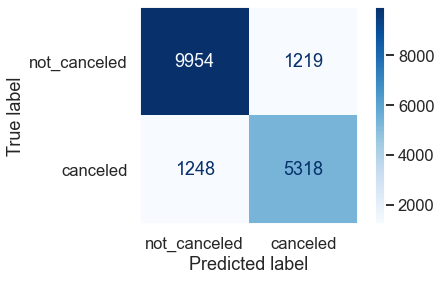

In [84]:
forest_matrix = plot_confusion_matrix(clf_dict['forest'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
forest_matrix

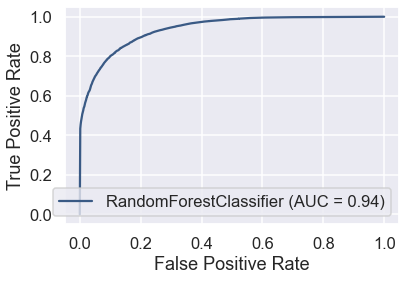

In [85]:
forest_roc = plot_roc_curve(clf_dict['forest'],X_val_processed, y_val);
forest_roc

#### Preliminary Evaluation

Pros:
- did very well on training data
- very balanced precision and recall scores
- did better on predicting positive class than some other models
- higher accuracy

Cons:
- severely overfitting 

Evaluate further: Yes

Tuning goals:
- reduce max depth to reduce overfitting
- increase number of estimators to reduce overfitting

### Gradient Boosting Classifier

In [86]:
GB_clf_file = 'files/GB_clf.pk1'
if 'GB_clf.pk1' in os.listdir('files'):
    GB_clf = joblib.load(GB_clf_file)
else:
    GB_clf = screen_model('GB_clf', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(GB_clf, GB_clf_file)
screen_dict['GB_clf'] = GB_clf
screen_dict['GB_clf']

{'fit_time mean': 30.099583196640015,
 'fit_time std': 0.13398903810527282,
 'score_time mean': 0.11694531440734864,
 'score_time std': 0.007472217947157347,
 'test_AUC mean': 0.9208664902585811,
 'test_AUC std': 0.008072854246389195,
 'train_AUC mean': 0.9235508351312302,
 'train_AUC std': 0.0031557365960636816,
 'test_Accuracy mean': 0.8298685022352357,
 'test_Accuracy std': 0.01143602284544493,
 'train_Accuracy mean': 0.833553124744083,
 'train_Accuracy std': 0.004724636735465866,
 'test_Recall mean': 0.8184475118059179,
 'test_Recall std': 0.027432739108661224,
 'train_Recall mean': 0.8251740911766543,
 'train_Recall std': 0.007063347185491511,
 'test_Precision mean': 0.8375620937489281,
 'test_Precision std': 0.0014994207930633654,
 'train_Precision mean': 0.8392238584076448,
 'train_Precision std': 0.0032671546249307816,
 'test_F1 mean': 0.8276725287567694,
 'test_F1 std': 0.014269808470716686,
 'train_F1 mean': 0.8321346300330316,
 'train_F1 std': 0.005157970251724855}

In [87]:
gb_report = get_report('GB_clf', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

gb_report

,precision,recall,f1-score,support
0,0.880773,0.848295,0.864229,11173.000000
1,0.757094,0.804599,0.780124,6566.000000
accuracy,0.832121,0.832121,0.832121,0.832121
macro avg,0.818933,0.826447,0.822177,17739.000000
weighted avg,0.834994,0.832121,0.833098,17739.000000


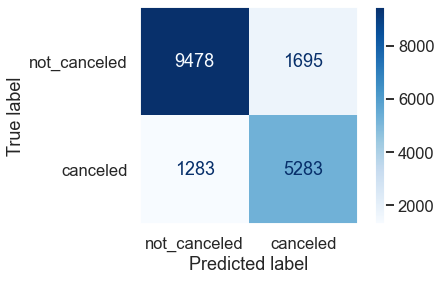

In [88]:
gb_matrix = plot_confusion_matrix(clf_dict['GB_clf'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

gb_matrix

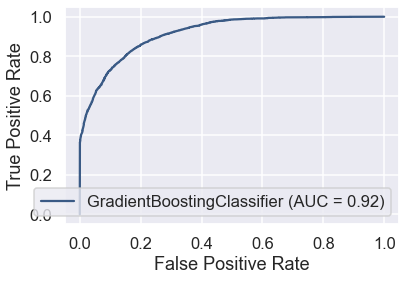

In [89]:
gb_roc = plot_roc_curve(clf_dict['GB_clf'],X_val_processed, y_val);
gb_roc

#### Preliminary Evaluation

Pros:
- not overfitting
- high precision on negative class

Cons:
- poor precision om the positive class compared to other metrics

Evaluate further: No

Tuning goals:

### ADA Boost

In [220]:
ada_file = 'files/ada.pk1'
if 'ada.pk1' in os.listdir('files'):
    ada = joblib.load(ada_file)
else:
    ada = screen_model('ada', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(ada, ada_file)
screen_dict['ada'] = ada
screen_dict['ada']

{'fit_time mean': 6.400963163375854,
 'fit_time std': 0.13204353143778116,
 'score_time mean': 0.37729597091674805,
 'score_time std': 0.03305671831970348,
 'test_AUC mean': 0.8997816136662788,
 'test_AUC std': 0.007928070142836838,
 'train_AUC mean': 0.9024484725868284,
 'train_AUC std': 0.002950650911643965,
 'test_Accuracy mean': 0.801636206745445,
 'test_Accuracy std': 0.008537037395700825,
 'train_Accuracy mean': 0.8051986239977275,
 'train_Accuracy std': 0.0036190588760204537,
 'test_Recall mean': 0.7662407269434061,
 'test_Recall std': 0.02201064844741177,
 'train_Recall mean': 0.7730346022304075,
 'train_Recall std': 0.005301312545127999,
 'test_Precision mean': 0.8246325250250452,
 'test_Precision std': 0.002206872384542829,
 'train_Precision mean': 0.8261735796738497,
 'train_Precision std': 0.00287434772392148,
 'test_F1 mean': 0.7941957281474921,
 'test_F1 std': 0.01163326130503432,
 'train_F1 mean': 0.7987179440943051,
 'train_F1 std': 0.004074538451067317}

In [91]:
ada_report = get_report('ada', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)

ada_report

,precision,recall,f1-score,support
0,0.856076,0.841135,0.848540,11173.000000
1,0.737465,0.759366,0.748255,6566.000000
accuracy,0.810869,0.810869,0.810869,0.810869
macro avg,0.796770,0.800251,0.798397,17739.000000
weighted avg,0.812173,0.810869,0.811420,17739.000000


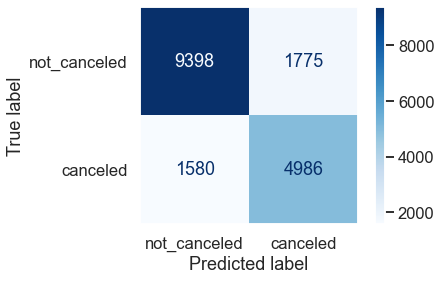

In [92]:
ada_matrix = plot_confusion_matrix(clf_dict['ada'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

ada_matrix

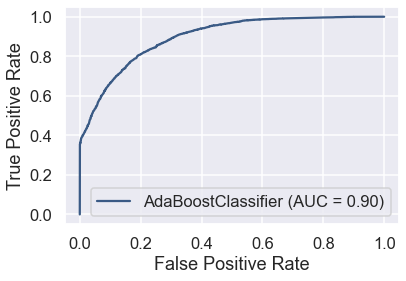

In [93]:
ada_roc = plot_roc_curve(clf_dict['ada'],X_val_processed, y_val);
ada_roc

#### Preliminary Evaluation

Pros:
- not overfitting
- balanced precision and recall scores

Cons:
- poor at predicting the positive class
- lower accuracy

Evaluate further: No

Tuning goals:

### XGBoost

In [94]:
xgb_file = 'files/xgb.pk1'
if 'xgb.pk1' in os.listdir('files'):
    xgb = joblib.load(xgb_file)
else:
    xgb = screen_model('xgb', 
                         clf_dict, 
                         scoring, 
                         X_train_smote, 
                         y_train_smote)
    joblib.dump(xgb, xgb_file)
screen_dict['xgb'] = xgb
screen_dict['xgb']

{'fit_time mean': 29.94925661087036,
 'fit_time std': 0.14224714018451928,
 'score_time mean': 0.29034934043884275,
 'score_time std': 0.003603388842559559,
 'test_AUC mean': 0.9529507162308967,
 'test_AUC std': 0.022058084067718708,
 'train_AUC mean': 0.9659339623060095,
 'train_AUC std': 0.005622251286157271,
 'test_Accuracy mean': 0.8714597895289014,
 'test_Accuracy std': 0.03436063414520849,
 'train_Accuracy mean': 0.8943977261598596,
 'train_Accuracy std': 0.009979982876986412,
 'test_Recall mean': 0.855752884622919,
 'test_Recall std': 0.08207237257427322,
 'train_Recall mean': 0.8855607595543658,
 'train_Recall std': 0.008084061598431886,
 'test_Precision mean': 0.8837314196350082,
 'test_Precision std': 0.002521577080485232,
 'train_Precision mean': 0.9015397208788164,
 'train_Precision std': 0.011711469643729877,
 'test_F1 mean': 0.8674420285119746,
 'test_F1 std': 0.04057235268416146,
 'train_F1 mean': 0.8934751901172447,
 'train_F1 std': 0.009855434858368053}

In [95]:
xgb_report = get_report('xgb', 
           clf_dict, 
           X_train_smote, 
           y_train_smote, 
           X_val_processed, 
           y_val)
xgb_report

,precision,recall,f1-score,support
0,0.883064,0.889466,0.886253,11173.000000
1,0.809561,0.799574,0.804536,6566.000000
accuracy,0.856193,0.856193,0.856193,0.856193
macro avg,0.846312,0.844520,0.845395,17739.000000
weighted avg,0.855857,0.856193,0.856006,17739.000000


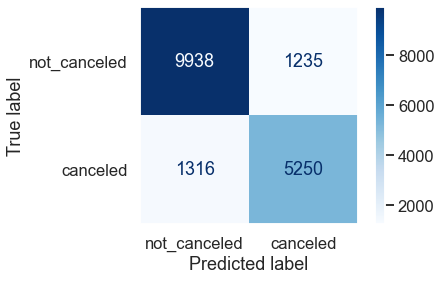

In [96]:
xgb_matrix = plot_confusion_matrix(clf_dict['xgb'], 
                      X_val_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)
xgb_matrix

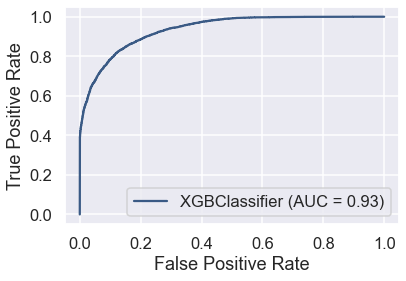

In [97]:
xgb_roc = plot_roc_curve(clf_dict['xgb'],X_val_processed, y_val);
xgb_roc

#### Preliminary Evaluation

Pros:
- balanced between precision and recall
- very high accuracy

Cons:
- some overfitting
- lower recall and precision on the positive class than random forest

Evaluate further: yes

Tuning goals:
- adjust learning rate and number of estimators

## Summary of Initial Models

In [98]:
initial_model_metrics = pd.DataFrame(screen_dict)
initial_model_metrics

,baseline,log_r,knn,svc,tree,forest,GB_clf,ada,xgb
fit_time mean,0.014979,6.947307,59.025218,475.209560,0.966484,9.763060,30.099583,6.400963,29.949257
fit_time std,0.001344,0.493153,0.665467,50.718843,0.015284,0.612136,0.133989,0.132044,0.142247
score_time mean,0.024806,0.031816,112.043722,82.059173,0.036896,0.453169,0.116945,0.377296,0.290349
score_time std,0.003056,0.006115,4.754436,0.701494,0.003665,0.070860,0.007472,0.033057,0.003603
test_AUC mean,0.501048,0.902462,0.928731,0.927361,0.852685,0.958018,0.920866,0.899782,0.952951
test_AUC std,0.004293,0.010746,0.015485,0.008361,0.022711,0.014915,0.008073,0.007928,0.022058
train_AUC mean,0.500843,0.903291,0.971838,0.933653,0.999891,0.999498,0.923551,0.902448,0.965934
train_AUC std,0.000799,0.002761,0.002956,0.002418,0.000026,0.000062,0.003156,0.002951,0.005622
test_Accuracy mean,0.535304,0.808435,0.855694,0.844800,0.849624,0.884569,0.829869,0.801636,0.871460
test_Accuracy std,0.004006,0.012891,0.016783,0.008763,0.022115,0.024924,0.011436,0.008537,0.034361


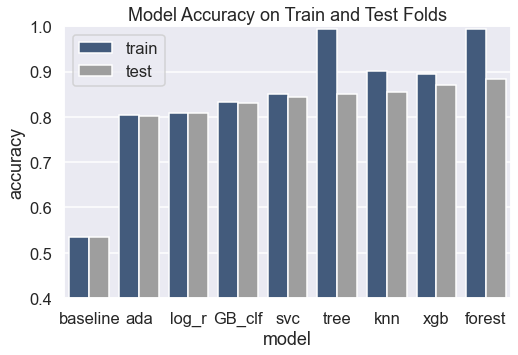

In [99]:
#Get the accuracy scores for the train and test folds for each of the models
accuracy = (initial_model_metrics.loc
            [['train_Accuracy mean','test_Accuracy mean']]).T.reset_index()
accuracy.columns = ['model', 'train', 'test']
accuracy = accuracy.sort_values('test')
acc_df = pd.melt(accuracy, 
             id_vars='model', 
             var_name='fold', 
             value_name='accuracy')

#Visualize the accuracy scores
fig,ax=plt.subplots(figsize=(8,5))
sns.barplot(data=acc_df, 
            x='model', 
            y='accuracy', 
            hue='fold', 
            ci=None)
plt.legend(loc='upper left')
plt.title('Model Accuracy on Train and Test Folds')
plt.ylim(.4, 1.0);

All of the models significantly improved upon the baseline accuracy. The following models exhibit signs of overfitting: tree, knn, xbg and forest.

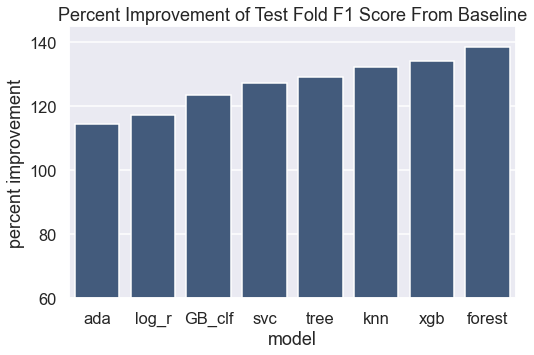

In [236]:
#Get the F1 scores for the train and test folds for each of the models
test_f1 = initial_model_metrics.loc['test_F1 mean'].reset_index()
test_f1.columns = ['model', 'f1']
baseline = initial_model_metrics['baseline']['test_F1 mean']
test_f1['percent_improvement_from_baseline'] = ((test_f1['f1'] - 
                                                 baseline)/baseline *100)
test_f1 = test_f1.sort_values('percent_improvement_from_baseline')
test_f1=test_f1[test_f1['model'] != 'baseline']

#Visualize the F1 scores
fig,ax=plt.subplots(figsize=(8,5))
sns.barplot(data=test_f1, 
            x='model', 
            y='percent_improvement_from_baseline', 
            color=NEUTRAL)
plt.title('Percent Improvement of Test Fold F1 Score From Baseline')
plt.ylabel('percent improvement')
plt.ylim(60,145);

All of the models more than doubled the baseline F1 score of 37.

In [101]:
#Create lists of the F1 scores for the majority and minority classes
majority_f1 = []
minority_f1 = []
for model in report_dict.keys():
    majority_f1.append(report_dict[model]['0']['f1-score'])
    minority_f1.append(report_dict[model]['1']['f1-score'])

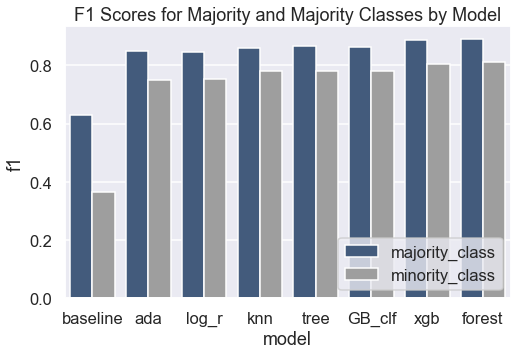

In [102]:
#Create a dataframe with the F1 scores
validation_f1 = pd.DataFrame({'clf' : report_dict.keys()})
validation_f1['majority_class'] = majority_f1
validation_f1['minority_class'] = minority_f1
validation_f1 = validation_f1.sort_values('minority_class')

#Visualize the F1 scores
fig,ax = plt.subplots(figsize=(8,5))
df = pd.melt(validation_f1, 
             id_vars='clf', 
             var_name='class', 
             value_name='f1')
sns.barplot(data=df, x='clf', y='f1', hue='class')
plt.legend(loc='lower right')

plt.xlabel('model')
plt.title('F1 Scores for Majority and Majority Classes by Model');

Because of the class imbalance, all of the models perform better on the majority class. 

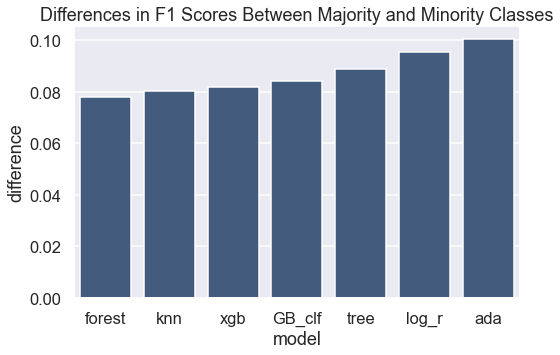

In [237]:
#Calculate the differences in F1 scores
validation_f1['difference'] = (validation_f1['majority_class'] - 
                               validation_f1['minority_class'] )
validation_f1 = validation_f1[validation_f1['clf'] !='baseline']
validation_f1=validation_f1.sort_values('difference')

#Visualize the differences in F1 scores
plt.subplots(figsize=(8,5))
sns.barplot(data=validation_f1, x='clf', y='difference', color=NEUTRAL)
plt.title('Differences in F1 Scores Between Majority and Minority Classes')
plt.xlabel('model');

Forest, svc, knn and xgb had the least amount of difference in the F1 scores between the minority and majority classes. 

In [104]:
#Create lists of the precision scores for the majority and minority classes
majority_prec = []
minority_prec = []
for model in report_dict.keys():
    majority_prec.append(report_dict[model]['0']['precision'])
    minority_prec.append(report_dict[model]['1']['precision'])
    

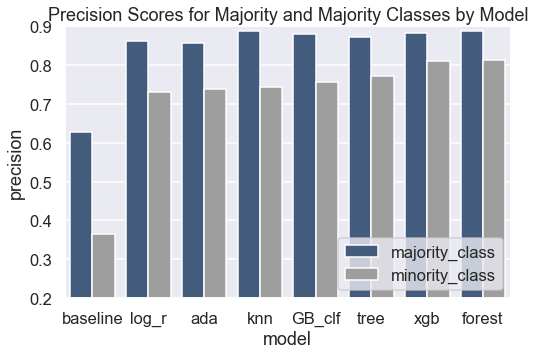

In [105]:
#Create a dataframe with the precision scores
validation_precision = pd.DataFrame({'clf' : report_dict.keys()})
validation_precision['majority_class'] = majority_prec
validation_precision['minority_class'] = minority_prec
validation_precision = validation_precision.sort_values('minority_class')

#Visualize the precision scores
fig,ax = plt.subplots(figsize=(8,5))
df = pd.melt(validation_precision, 
             id_vars='clf', 
             var_name='class', 
             value_name='precision')
sns.barplot(data=df, x='clf', y='precision', hue='class')
plt.legend(loc='lower right')
plt.ylim(.2, .9)
plt.xlabel('model')
plt.title('Precision Scores for Majority and Majority Classes by Model');

The models are weakest in precision on the minority class. In other words, they have a tendency to predict that customers don't cancel, when in fact they do. SVC, xgb and random forest have the highest precision for the minority class. 

The following models had high accuracy scores, high F1 scores, a smaller difference in F1 between the classes and higher precision scores for the minority class:
- Support Vector Classifier
- Random Forest
- XG Boost

I will tune each of these models to try to improve their performance further.

## Evaluating Features

### Preliminary Feature Importances From Random Forest

In [106]:
#Get the feature importances in a dataframe
rf = clf_dict['forest']
rf.fit(X_train_smote, y_train_smote)
prelim_feature_importances = pd.DataFrame(list(
    zip(
        feature_names, 
        rf.feature_importances_))).sort_values(
    1, ascending=False)
prelim_feature_importances.columns = ['feature', 'importance']

In [107]:
#Examine the top 5 features
prelim_feature_importances[:5]

,feature,importance
6,adr,0.149139
0,arrival_date_week_number,0.133980
4,deposit_made,0.090242
8,stay_length,0.084281
24,country_PRT,0.073678


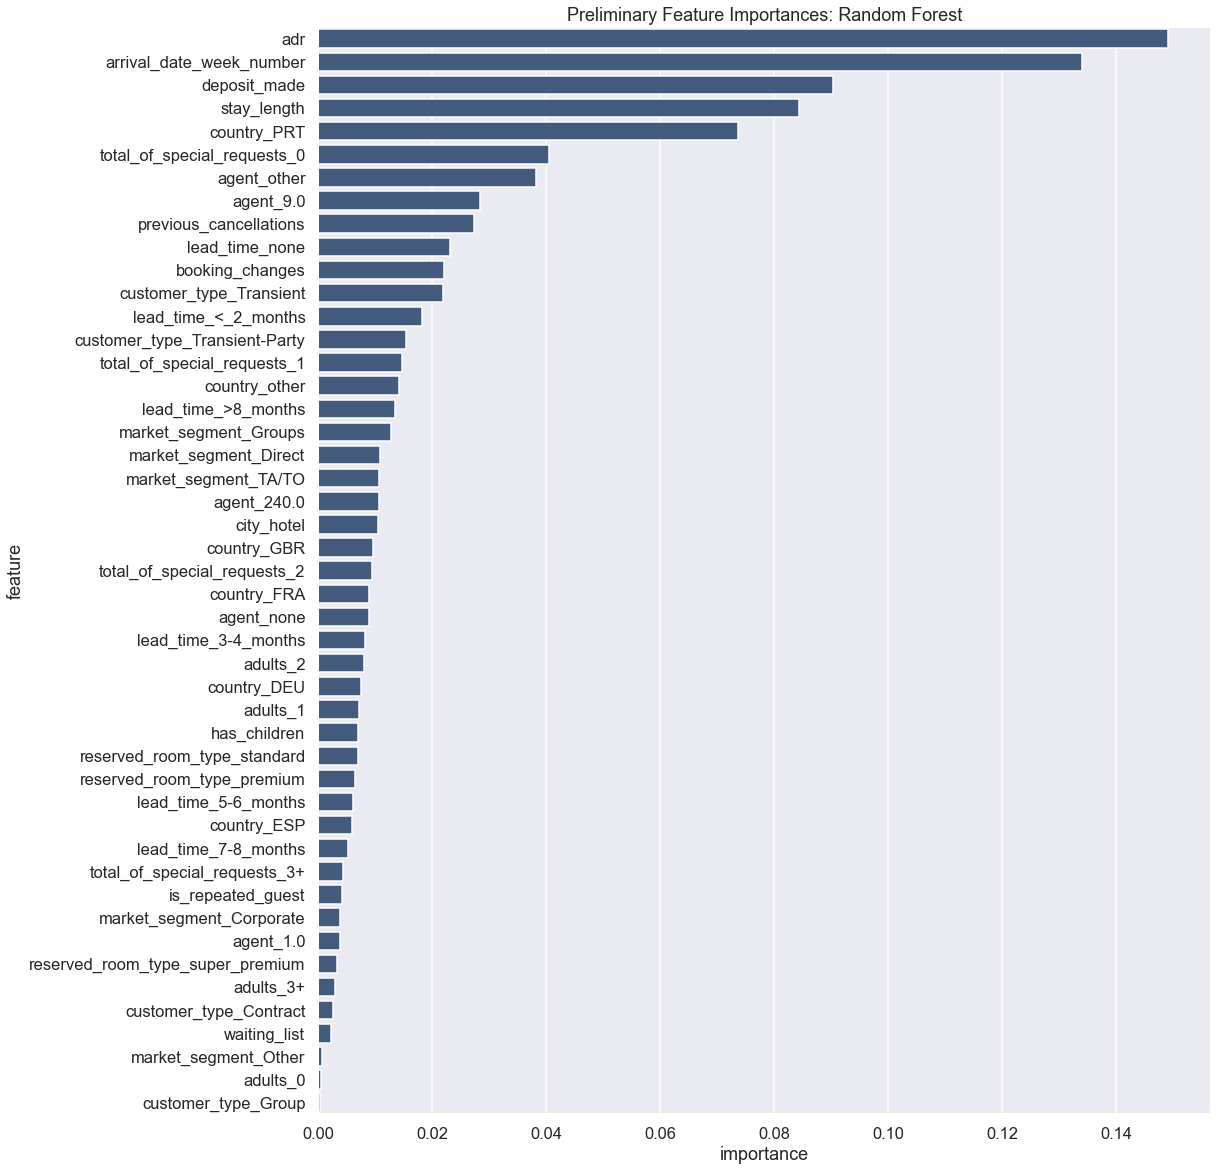

In [108]:
#Visualize the feature importances
fig,ax = plt.subplots(figsize=(16,20))
sns.barplot(data=prelim_feature_importances, 
            x='importance',
            y='feature',
            color = NEUTRAL)
plt.title('Preliminary Feature Importances: Random Forest');

Based on the current Random Forest model, the following features are the most important:
- average daily rate (15%)
- arrival date week number (13%)
- deposit made (9%)
- length of stay (8%)
- country Portugal (7%)

The following features have little to no importance (less than 1%):
- country_GBR
- lead_time_5-6_months
- adults_2
- has_children
- country_FRA
- adults_1
- lead_time_7-8_months
- is_repeated_guest
- reserved_room_type_super_premium
- adults_3+
- waiting_list
- market_segment_Other
- customer_type_Group

### Preliminary Feature Importances From XGBoost

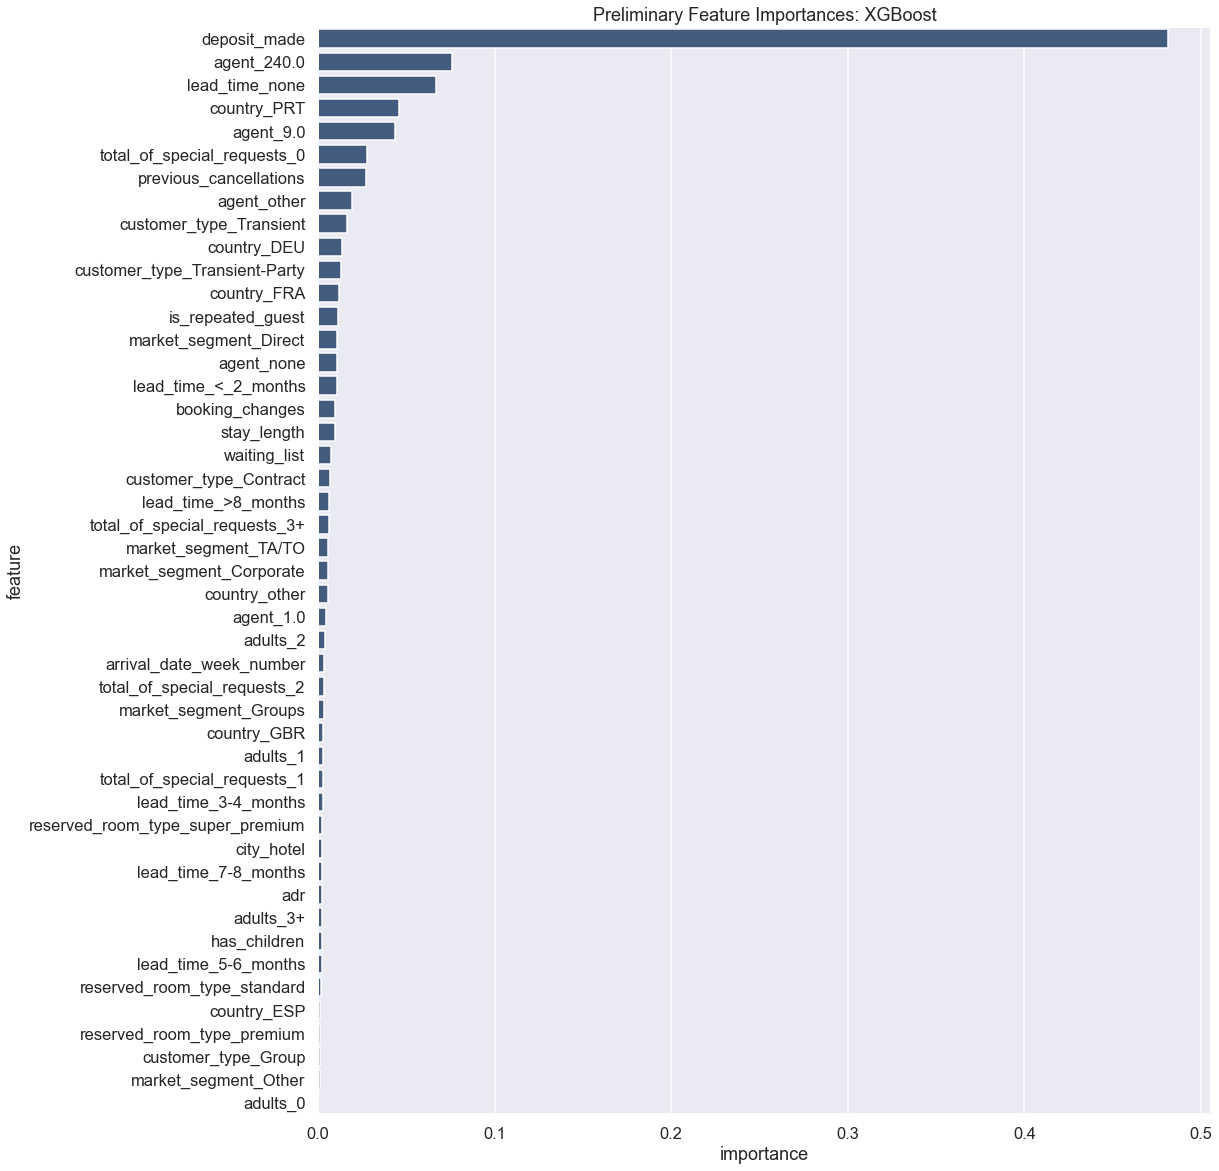

In [109]:
#Get the feature importances as a dataframe
xg = clf_dict['xgb']
xg.fit(X_train_smote, y_train_smote)
prelim_feature_importances_xg = pd.DataFrame(list(
    zip(
        feature_names, 
        xg.feature_importances_))).sort_values(
    1, ascending=False)
prelim_feature_importances_xg.columns = ['feature', 'importance']

#Visualize the feature_importances
fig,ax = plt.subplots(figsize=(16,20))
sns.barplot(data=prelim_feature_importances_xg, 
            x='importance',
            y='feature',
            color = NEUTRAL)
plt.title('Preliminary Feature Importances: XGBoost');

According to XGBoost, the most important feature by far is the requirement of a deposit. Many of the least important features are also ranked in the bottom for random forest. These are features to consider dropping. 

### Removing Non-Important Features

In [110]:
#Remove the non-important features and reprocess the data
X_train = X_train.copy()
X_val = X_val.copy()

features_to_drop = ['adults', 'is_repeated_guest','reserved_room_type', 
                    'waiting_list']
X_train_reduced = X_train.drop(features_to_drop, axis=1)

cat_cols_reduced = X_train_reduced.select_dtypes('object').columns
num_cols_reduced = X_train_reduced.select_dtypes('number').columns

transformer_reduced = ColumnTransformer([
    ('num', num_transformer, num_cols_reduced),
    ('cat', cat_transformer, cat_cols_reduced),
    ])

preprocess_reduced = Pipeline([('transformer', transformer_reduced)])

X_train_reduced_processed = preprocess_reduced.fit_transform(X_train_reduced)

X_val_reduced = X_val.drop(features_to_drop, axis=1)
X_val_reduced_processed = preprocess_reduced.transform(X_val_reduced)


cat_names_reduced = (preprocess_reduced.named_steps['transformer']
             .transformers_[1][1].named_steps['ohe']
             .get_feature_names(cat_cols_reduced))
feature_names_reduced = list(num_cols_reduced) + list(cat_names_reduced)

i_1r = len(num_cols_reduced)+1
i_2r = len(feature_names_reduced)

oversampler_r = SMOTENC(categorical_features = list(range(i_1r,i_2r)), 
                      n_jobs=-2, 
                      random_state=SEED)

In [111]:
X_reduced_smote_file = 'files/X_reduced_smote.pk1'
y_reduced_smote_file = 'files/y_reduced_smote.pk1'

if ('X_reduced_smote.pk1' in os.listdir('files') and 
    'y_reduced_smote.pk1' in os.listdir('files')):
    X_train_reduced_smote = joblib.load(X_reduced_smote_file)
    y_train_reduced_smote = joblib.load(y_reduced_smote_file)
else:
    X_train_reduced_smote, y_train_reduced_smote = oversampler_r.fit_resample(
    X_train_reduced_processed, y_train)
    joblib.dump(X_train_reduced_smote, X_reduced_smote_file)
    joblib.dump(y_train_reduced_smote, y_reduced_smote_file)
X_train_reduced_smote.shape, y_train_reduced_smote.shape

((104278, 38), (104278,))

### Evaluating the Models After Feature Reduction

#### Support Vector Classifier

In [112]:
reduced_svc_file = 'files/reduced_svc.pk1'
if 'reduced_svc.pk1' in os.listdir('files'):
    reduced_svc = joblib.load(reduced_svc_file)
else:
    reduced_svc = screen_model('svc', 
                            clf_dict, 
                            scoring, 
                            X_train_reduced_smote, 
                            y_train_reduced_smote)
    joblib.dump(reduced_svc, reduced_svc_file)
reduced_svc

{'fit_time mean': 360.1355924606323,
 'fit_time std': 34.912544291915815,
 'score_time mean': 69.76401810646057,
 'score_time std': 0.4949632570838212,
 'test_AUC mean': 0.9247772803517116,
 'test_AUC std': 0.007016271321338005,
 'train_AUC mean': 0.9305374799795143,
 'train_AUC std': 0.0019478861154797493,
 'test_Accuracy mean': 0.8383457296471508,
 'test_Accuracy std': 0.0067567676015919285,
 'train_Accuracy mean': 0.8443295967244502,
 'train_Accuracy std': 0.002856055606008613,
 'test_Recall mean': 0.8226283218646643,
 'test_Recall std': 0.01655455476247173,
 'train_Recall mean': 0.8298538702346594,
 'train_Recall std': 0.003643230085283713,
 'test_Precision mean': 0.8493338723708085,
 'test_Precision std': 0.0016206363603308324,
 'train_Precision mean': 0.8545927180536932,
 'train_Precision std': 0.002462011872668645,
 'test_F1 mean': 0.8356807827308396,
 'test_F1 std': 0.008450627548358762,
 'train_F1 mean': 0.842040762713214,
 'train_F1 std': 0.003017184524548519}

In [113]:
svc_reduced_report_file = 'files/svc_reduced_report.pk1'
if 'svc_reduced_report.pk1' in os.listdir('files'):
    svc_reduced_report = joblib.load(svc_reduced_report_file)
else:
    svc_reduced_report = get_report('svc', 
                   clf_dict, 
                   X_train_reduced_smote, 
                   y_train_reduced_smote, 
                   X_val_reduced_processed, 
                   y_val)
    joblib.dump(svc_reduced_report, svc_reduced_report_file)
    
print('Original SVC Report')
print(svc_report)
print('\n\n')
print('SVC Reduced Features Report')
print(svc_reduced_report)

Original SVC Report
              precision    recall  f1-score      support
0              0.888400  0.867090  0.877616  11173.00000
1              0.782704  0.814651  0.798358   6566.00000
accuracy       0.847680  0.847680  0.847680      0.84768
macro avg      0.835552  0.840871  0.837987  17739.00000
weighted avg   0.849277  0.847680  0.848279  17739.00000



SVC Reduced Features Report
                      0            1  accuracy     macro avg  weighted avg
precision      0.885457     0.775397  0.842889      0.830427      0.844719
recall         0.862078     0.810235  0.842889      0.836156      0.842889
f1-score       0.873611     0.792433  0.842889      0.833022      0.843564
support    11173.000000  6566.000000  0.842889  17739.000000  17739.000000


The SVC model did slightly worse with the feature reduction.

#### Random Forest

In [114]:
reduced_random_forest = screen_model('xgb', 
                                     clf_dict, 
                                     scoring, 
                                     X_train_reduced_smote, 
                                     y_train_reduced_smote)
reduced_random_forest

{'fit_time mean': 25.530458450317383,
 'fit_time std': 0.1627078394540675,
 'score_time mean': 0.2745504856109619,
 'score_time std': 0.016644439672632762,
 'test_AUC mean': 0.9518096107936586,
 'test_AUC std': 0.02285119421206293,
 'train_AUC mean': 0.964240866032392,
 'train_AUC std': 0.005825075896585354,
 'test_Accuracy mean': 0.8701172538902465,
 'test_Accuracy std': 0.03569860993441283,
 'train_Accuracy mean': 0.8917677395980788,
 'train_Accuracy std': 0.01038773700188209,
 'test_Recall mean': 0.8544102570158343,
 'test_Recall std': 0.08357556631803759,
 'train_Recall mean': 0.8828468622159326,
 'train_Recall std': 0.008086726743807164,
 'test_Precision mean': 0.8822151807841238,
 'test_Precision std': 0.0016380146841882127,
 'train_Precision mean': 0.8989431279049164,
 'train_Precision std': 0.012429605359360347,
 'test_F1 mean': 0.8660018350058794,
 'test_F1 std': 0.04199640842541274,
 'train_F1 mean': 0.8908173033383369,
 'train_F1 std': 0.010217012811884665}

In [115]:
forest_reduced_report = get_report('forest', 
           clf_dict, 
           X_train_reduced_smote, 
           y_train_reduced_smote, 
           X_val_reduced_processed, 
           y_val)

print('Original Random Forest Report')
print(forest_report)
print('\n\n')
print('Random Forest Reduced Features Report')
print(forest_reduced_report)

Original Random Forest Report
              precision    recall  f1-score       support
0              0.888591  0.890898  0.889743  11173.000000
1              0.813523  0.809930  0.811723   6566.000000
accuracy       0.860928  0.860928  0.860928      0.860928
macro avg      0.851057  0.850414  0.850733  17739.000000
weighted avg   0.860805  0.860928  0.860864  17739.000000



Random Forest Reduced Features Report
              precision    recall  f1-score       support
0              0.888164  0.889197  0.888680  11173.000000
1              0.811079  0.809473  0.810275   6566.000000
accuracy       0.859688  0.859688  0.859688      0.859688
macro avg      0.849621  0.849335  0.849478  17739.000000
weighted avg   0.859631  0.859688  0.859659  17739.000000


The Random Forest model did slightly worse on the validation set with the feature reduction. However, the overfitting has been greatly reduced.

#### XGBoost

In [116]:
reduced_xgb = screen_model('xgb', 
                            clf_dict, 
                            scoring, 
                            X_train_reduced_smote, 
                            y_train_reduced_smote)
reduced_xgb

{'fit_time mean': 22.53233675956726,
 'fit_time std': 0.2024256511495024,
 'score_time mean': 0.2532802104949951,
 'score_time std': 0.012687892190782587,
 'test_AUC mean': 0.9518096107936586,
 'test_AUC std': 0.02285119421206293,
 'train_AUC mean': 0.964240866032392,
 'train_AUC std': 0.005825075896585354,
 'test_Accuracy mean': 0.8701172538902465,
 'test_Accuracy std': 0.03569860993441283,
 'train_Accuracy mean': 0.8917677395980788,
 'train_Accuracy std': 0.01038773700188209,
 'test_Recall mean': 0.8544102570158343,
 'test_Recall std': 0.08357556631803759,
 'train_Recall mean': 0.8828468622159326,
 'train_Recall std': 0.008086726743807164,
 'test_Precision mean': 0.8822151807841238,
 'test_Precision std': 0.0016380146841882127,
 'train_Precision mean': 0.8989431279049164,
 'train_Precision std': 0.012429605359360347,
 'test_F1 mean': 0.8660018350058794,
 'test_F1 std': 0.04199640842541274,
 'train_F1 mean': 0.8908173033383369,
 'train_F1 std': 0.010217012811884665}

In [117]:
xgb_reduced_report = get_report('xgb', 
           clf_dict, 
           X_train_reduced_smote, 
           y_train_reduced_smote, 
           X_val_reduced_processed, 
           y_val)

print('Original XGBoost Report')
print(xgb_report)
print('\n\n')
print('XGBoost Reduced Features Report')
print(xgb_reduced_report)

Original XGBoost Report
              precision    recall  f1-score       support
0              0.883064  0.889466  0.886253  11173.000000
1              0.809561  0.799574  0.804536   6566.000000
accuracy       0.856193  0.856193  0.856193      0.856193
macro avg      0.846312  0.844520  0.845395  17739.000000
weighted avg   0.855857  0.856193  0.856006  17739.000000



XGBoost Reduced Features Report
              precision    recall  f1-score       support
0              0.885370  0.888302  0.886834  11173.000000
1              0.808853  0.804295  0.806567   6566.000000
accuracy       0.857207  0.857207  0.857207      0.857207
macro avg      0.847112  0.846299  0.846701  17739.000000
weighted avg   0.857048  0.857207  0.857124  17739.000000


The XGBoost model performed slightly better with the feature reduction.

Since reducing the features changed the the metrics only slightly, but did significantly improve overfitting, I will use the reduced features for tuning the models. 

## Model Tuning

In [118]:
#Hyperparameter grid for grid search
hyperparameter_dict = {
    'forest': [{
        'bootstrap': [True, False],
        'max_depth': [3,10, None],
        'max_features': [3, 'sqrt', 15],
        'n_estimators': [1000, 2000],
        'max_samples': [.2, .6, None]
    }],
    'xgb': [{
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 10, None]
    }]
}


def tune_model(clf, clf_dict, hyperparameter_dict, scoring, X,y):
    """Takes in the model's key from the clf dictionary, a classifier
    dictionary, a hyperparameter dictionary, a scoring dictionary and and X 
    and y. A gridsearch is then performed using the 
    specified classifier and its associated hyperparameters from the
    hyperparameter dictonary. After the model is fitted, a
    GridSearchCV object is then returned."""
    
    
    model = GridSearchCV(clf_dict[clf],
                        hyperparameter_dict[clf], 
                        cv=3,
                        scoring = scoring,
                        refit = 'F1',
                        return_train_score=True,
                        n_jobs=-2,
                        error_score="raise")
    model.fit(X,y)
    
    return model

model_compare = {}

def score_model(model, clf):
    """Takes in a model and its key from the clf dictionary and returns
    a dictionary with its scoring metrics. It also appends this dictionary
    to the model_compare dictionary."""
    
    model_eval_dict = {}
    
    model_eval_dict['train_accuracy'] = (
        model.cv_results_['mean_train_Accuracy']).mean()
    model_eval_dict['test_accuracy'] = (
        model.cv_results_['mean_test_Accuracy']).mean()
    
    model_eval_dict['AUC_train'] = (
        model.cv_results_['mean_train_AUC']).mean()
    model_eval_dict['AUC_test'] = (
        model.cv_results_['mean_test_AUC']).mean()
    
    model_eval_dict['train_f1'] = (
        model.cv_results_['mean_train_F1']).mean()
    model_eval_dict['test_f1'] = (
        model.cv_results_['mean_test_F1']).mean()
    
    model_eval_dict['train_recall'] = (
        model.cv_results_['mean_train_Recall']).mean()
    model_eval_dict['test_recall'] = (
        model.cv_results_['mean_test_Recall']).mean()
    
    model_eval_dict['train_precision'] = (
        model.cv_results_['mean_train_Precision']).mean()
    model_eval_dict['test_precision'] = (
        model.cv_results_['mean_test_Precision']).mean()
    
    
    model_eval_dict['best_params'] = model.best_params_
    
    
    for k,v in model_eval_dict.items():
        print(f"{k}: {v}")
    
    model_compare[clf] = model_eval_dict

    
    return model_compare
    

### SVC

In [119]:
svc_report_linear_file = 'files/svc_report_linear.pk1'
if 'svc_report_linear.pk1' in os.listdir('files'):
    svc_report_linear = pd.DataFrame(joblib.load(svc_report_linear_file)).T
else:
    svc_tune_l = SVC(random_state=SEED, kernel='linear')
    svc_tune_l.fit(X_train_reduced_smote, y_train_reduced_smote)
    svc_pred_l = svc_tune_l.predict(X_val_reduced_processed)
    svc_report_linear = pd.DataFrame(classification_report(y_val, 
                                                           svc_pred_l, 
                                                           output_dict=True))
    joblib.dump(svc_report_linear, svc_report_linear_file)
svc_report_linear

,precision,recall,f1-score,support
0,0.861041,0.799159,0.828947,11173.000000
1,0.695481,0.780536,0.735558,6566.000000
accuracy,0.792266,0.792266,0.792266,0.792266
macro avg,0.778261,0.789847,0.782252,17739.000000
weighted avg,0.799760,0.792266,0.794379,17739.000000


In [120]:
svc_report_C_file = 'files/svc_report_C.pk1'
if 'svc_report_C.pk1' in os.listdir('files'):
    svc_report_C = pd.DataFrame(joblib.load(svc_report_C_file)).T
else:
    svc_tune_C = SVC(random_state=SEED, C=10)
    svc_tune_C.fit(X_train_reduced_smote, y_train_reduced_smote)
    svc_pred_C = svc_tune_C.predict(X_val_reduced_processed)
    svc_report_C = pd.DataFrame(classification_report(y_val, 
                                                  svc_pred_C, 
                                                  output_dict=True))
    joblib.dump(svc_report_C, svc_report_C_file)
svc_report_C

,precision,recall,f1-score,support
0,0.892980,0.859572,0.875958,11173.000000
1,0.775344,0.824703,0.799262,6566.000000
accuracy,0.846666,0.846666,0.846666,0.846666
macro avg,0.834162,0.842138,0.837610,17739.000000
weighted avg,0.849438,0.846666,0.847569,17739.000000


In [121]:
svc_report

,precision,recall,f1-score,support
0,0.888400,0.867090,0.877616,11173.00000
1,0.782704,0.814651,0.798358,6566.00000
accuracy,0.847680,0.847680,0.847680,0.84768
macro avg,0.835552,0.840871,0.837987,17739.00000
weighted avg,0.849277,0.847680,0.848279,17739.00000


### Random Forest

In [122]:
forest_grid_file = 'files/forest_grid.pk1'
if 'forest_grid.pk1' in os.listdir('files'):
    forest_grid = joblib.load(forest_grid_file)
else:
    forest_grid = tune_model('forest', 
                         clf_dict, 
                         hyperparameter_dict, 
                         scoring, 
                         X_train_reduced_smote,
                         y_train_reduced_smote)
    joblib.dump(forest_grid,forest_grid_file)
forest_grid 

GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-2, random_state=85),
             n_jobs=-2,
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [3, 10, None],
                          'max_features': [3, 'sqrt', 15],
                          'max_samples': [0.2, 0.6, None],
                          'n_estimators': [1000, 2000]}],
             refit='F1', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'F1': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)})

In [123]:
score_model(forest_grid, 'forest')

train_accuracy: 0.8618769771709888
test_accuracy: 0.8241538061440494
AUC_train: 0.9364564134120791
AUC_test: 0.9189199124132867
train_f1: 0.8465816113315632
test_f1: 0.8082470510756404
train_recall: 0.8019524017513928
test_recall: 0.7625039877488423
train_precision: 0.9068776402386383
test_precision: 0.8704013467029527
best_params: {'bootstrap': True, 'max_depth': None, 'max_features': 15, 'max_samples': None, 'n_estimators': 2000}


{'forest': {'train_accuracy': 0.8618769771709888,
  'test_accuracy': 0.8241538061440494,
  'AUC_train': 0.9364564134120791,
  'AUC_test': 0.9189199124132867,
  'train_f1': 0.8465816113315632,
  'test_f1': 0.8082470510756404,
  'train_recall': 0.8019524017513928,
  'test_recall': 0.7625039877488423,
  'train_precision': 0.9068776402386383,
  'test_precision': 0.8704013467029527,
  'best_params': {'bootstrap': True,
   'max_depth': None,
   'max_features': 15,
   'max_samples': None,
   'n_estimators': 2000}}}

In [124]:
print('Original Cross Validation')
screen_dict['forest']

Original Cross Validation


{'fit_time mean': 9.763059997558594,
 'fit_time std': 0.6121361766582489,
 'score_time mean': 0.45316901206970217,
 'score_time std': 0.07085964609182009,
 'test_AUC mean': 0.958018012839819,
 'test_AUC std': 0.014914826433504419,
 'train_AUC mean': 0.9994975518532909,
 'train_AUC std': 6.159525607791054e-05,
 'test_Accuracy mean': 0.8845687582727543,
 'test_Accuracy std': 0.024924455668264723,
 'train_Accuracy mean': 0.993169705351107,
 'train_Accuracy std': 0.0008789190613168239,
 'test_Recall mean': 0.8826804187691148,
 'test_Recall std': 0.059828514455909074,
 'train_Recall mean': 0.9934597939920808,
 'train_Recall std': 0.0007681056509052539,
 'test_Precision mean': 0.886167375963069,
 'test_Precision std': 0.0021629655269323417,
 'train_Precision mean': 0.992884078785534,
 'train_Precision std': 0.0010250399367002514,
 'test_F1 mean': 0.883348812255447,
 'test_F1 std': 0.028645798222837398,
 'train_F1 mean': 0.9931718024584925,
 'train_F1 std': 0.0008777108105875681}

In [183]:
forest_best = forest_grid.best_estimator_

y_pred_forest = forest_best.predict(X_val_reduced_processed)

pd.DataFrame(classification_report(y_val, y_pred_forest, output_dict=True)).T

,precision,recall,f1-score,support
0,0.891479,0.893314,0.892396,11173.00000
1,0.817821,0.814956,0.816386,6566.00000
accuracy,0.864310,0.864310,0.864310,0.86431
macro avg,0.854650,0.854135,0.854391,17739.00000
weighted avg,0.864215,0.864310,0.864261,17739.00000


In [126]:
print('Original report')
forest_report

Original report


,precision,recall,f1-score,support
0,0.888591,0.890898,0.889743,11173.000000
1,0.813523,0.809930,0.811723,6566.000000
accuracy,0.860928,0.860928,0.860928,0.860928
macro avg,0.851057,0.850414,0.850733,17739.000000
weighted avg,0.860805,0.860928,0.860864,17739.000000


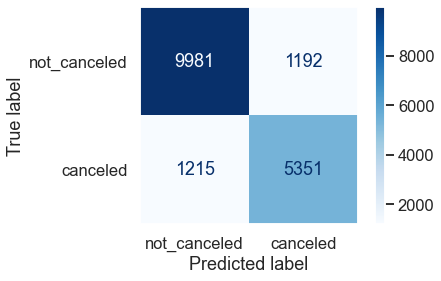

In [127]:
best_forest_matrix = plot_confusion_matrix(forest_best, 
                      X_val_reduced_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

best_forest_matrix

Overfitting has been reduced. The accuracy on the test folds decreased during cross validation, but the accuracy increased on the validation set. Based on the standard deviation of the accuracy results in the original cross validation, there is some variability in the results, so the increase in the validation set may be due to random chance. Recall and F1 increased slightly for the minority class and precision and recall are balanced. 

### XGBoost

In [128]:
xgb_grid_file = 'files/xgb_grid.pk1'
if 'xgb_grid.pk1' in os.listdir('files'):
    xgb_grid = joblib.load(xgb_grid_file)
else:
    xgb_grid = tune_model('xgb', 
                         clf_dict, 
                         hyperparameter_dict, 
                         scoring, 
                         X_train_reduced_smote,
                         y_train_reduced_smote)
    joblib.dump(xgb_grid, xgb_grid_file)
xgb_grid 

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n...
             param_grid=[{'colsample_bytree': [0.6, 0.8, 1.0],
                          'gamma': [0.5, 1, 1.5, 2, 5],
                          'max_depth': [3, 10, None],
                          'min_child_weight': [1, 5, 10],
                          'subsample': [0.6, 0.8, 1

In [129]:
score_model(xgb_grid, 'xgb')

train_accuracy: 0.8872881114880754
test_accuracy: 0.8576425349202061
AUC_train: 0.9594792342000478
AUC_test: 0.9431277547468737
train_f1: 0.8864471491967557
test_f1: 0.8536081294301139
train_recall: 0.8797343537165744
test_recall: 0.8386130324434785
train_precision: 0.8932981220075883
test_precision: 0.8728271968586259
best_params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8}


{'forest': {'train_accuracy': 0.8618769771709888,
  'test_accuracy': 0.8241538061440494,
  'AUC_train': 0.9364564134120791,
  'AUC_test': 0.9189199124132867,
  'train_f1': 0.8465816113315632,
  'test_f1': 0.8082470510756404,
  'train_recall': 0.8019524017513928,
  'test_recall': 0.7625039877488423,
  'train_precision': 0.9068776402386383,
  'test_precision': 0.8704013467029527,
  'best_params': {'bootstrap': True,
   'max_depth': None,
   'max_features': 15,
   'max_samples': None,
   'n_estimators': 2000}},
 'xgb': {'train_accuracy': 0.8872881114880754,
  'test_accuracy': 0.8576425349202061,
  'AUC_train': 0.9594792342000478,
  'AUC_test': 0.9431277547468737,
  'train_f1': 0.8864471491967557,
  'test_f1': 0.8536081294301139,
  'train_recall': 0.8797343537165744,
  'test_recall': 0.8386130324434785,
  'train_precision': 0.8932981220075883,
  'test_precision': 0.8728271968586259,
  'best_params': {'colsample_bytree': 0.8,
   'gamma': 0.5,
   'max_depth': 10,
   'min_child_weight': 1,
  

In [130]:
print('Original Cross Validation')
screen_dict['xgb']

Original Cross Validation


{'fit_time mean': 22.53233675956726,
 'fit_time std': 0.2024256511495024,
 'score_time mean': 0.2532802104949951,
 'score_time std': 0.012687892190782587,
 'test_AUC mean': 0.9518096107936586,
 'test_AUC std': 0.02285119421206293,
 'train_AUC mean': 0.964240866032392,
 'train_AUC std': 0.005825075896585354,
 'test_Accuracy mean': 0.8701172538902465,
 'test_Accuracy std': 0.03569860993441283,
 'train_Accuracy mean': 0.8917677395980788,
 'train_Accuracy std': 0.01038773700188209,
 'test_Recall mean': 0.8544102570158343,
 'test_Recall std': 0.08357556631803759,
 'train_Recall mean': 0.8828468622159326,
 'train_Recall std': 0.008086726743807164,
 'test_Precision mean': 0.8822151807841238,
 'test_Precision std': 0.0016380146841882127,
 'train_Precision mean': 0.8989431279049164,
 'train_Precision std': 0.012429605359360347,
 'test_F1 mean': 0.8660018350058794,
 'test_F1 std': 0.04199640842541274,
 'train_F1 mean': 0.8908173033383369,
 'train_F1 std': 0.010217012811884665}

In [131]:
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_val_reduced_processed)

print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11173
           1       0.82      0.80      0.81      6566

    accuracy                           0.86     17739
   macro avg       0.85      0.85      0.85     17739
weighted avg       0.86      0.86      0.86     17739



In [132]:
print('Original report')
xgb_report

Original report


,precision,recall,f1-score,support
0,0.883064,0.889466,0.886253,11173.000000
1,0.809561,0.799574,0.804536,6566.000000
accuracy,0.856193,0.856193,0.856193,0.856193
macro avg,0.846312,0.844520,0.845395,17739.000000
weighted avg,0.855857,0.856193,0.856006,17739.000000


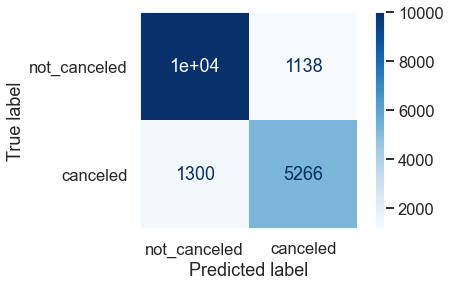

In [133]:
best_xgb_matrix = plot_confusion_matrix(xgb_best, 
                      X_val_reduced_processed, 
                      y_val,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

best_forest_matrix

### Summary

SVC did not improve with tuning (which was minimal due to run time) and since the interpretability of the results is important, I am going to focus on the random forest and XGBoost models. 

There is still some overfitting (although greatly reduced with feature removal and pruning), with the biggest impact seen in recall and overall accuracy. However, even with the overfitting, the model is still consistent with the validation data. 

Because of the imbalanced classes, both models do better at predicting the majority class (not canceled) than the minority one (canceled).

Random Forest
- Overall accuracy is 86%; the model's predictions are correct 86.1% of the time. 
- Of those that actually canceled, 81.5% of them were correctly predicted to cancel (recall). 
- Of those that were predicted to cancel, 81.8% of them actually did (precision).
- The false negative rate is 18.5%, which means that 18.5% of the actual cancellations were incorrectly predicted to keep their reservation.
- The false positive rate is 10.6%, which means that 10.6% of the customers who did not cancel were incorrectly predicted to cancel. 
- Overall, the model is more likely to miss cancellations than to incorrectly identify a customer as likely to cancel. 

XGBoost
- Overall accuracy is 86%; the model's predictions are correct 86% of the time. 
- Of those that actually canceled, 80.2% of them were correctly predicted to cancel (recall). 
- Of those that were predicted to cancel, 82.2% of them actually did (precision).
- The false negative rate is 19.8%, which means that 19.8% of the actual cancellations were incorrectly predicted to keep their reservation.
- The false positive rate is 10.2%, which means that 10.2% of the customers who did not cancel were incorrectly predicted to cancel. 
- Overall, the model is more likely to miss cancellations than to incorrectly identify a customer as likely to cancel. 

Because the random forest model does slightly better at picking up on cancellations than XGBoost, I am going to proceed with that model.

## Final Model Selection and Evaluation

### Model Selection

### Investigating the Removal of Additional Features

Now that the model is tuned, I will again look at the least impactful features and try removing them.

In [134]:
#Get feature importances
final_forest_features = pd.DataFrame(list(zip(feature_names_reduced, 
                                              forest_grid.best_estimator_
                                              .feature_importances_)))
final_forest_features.columns = ['feature','importance']
final_forest_features = final_forest_features.sort_values('importance', 
                                                          ascending=False)

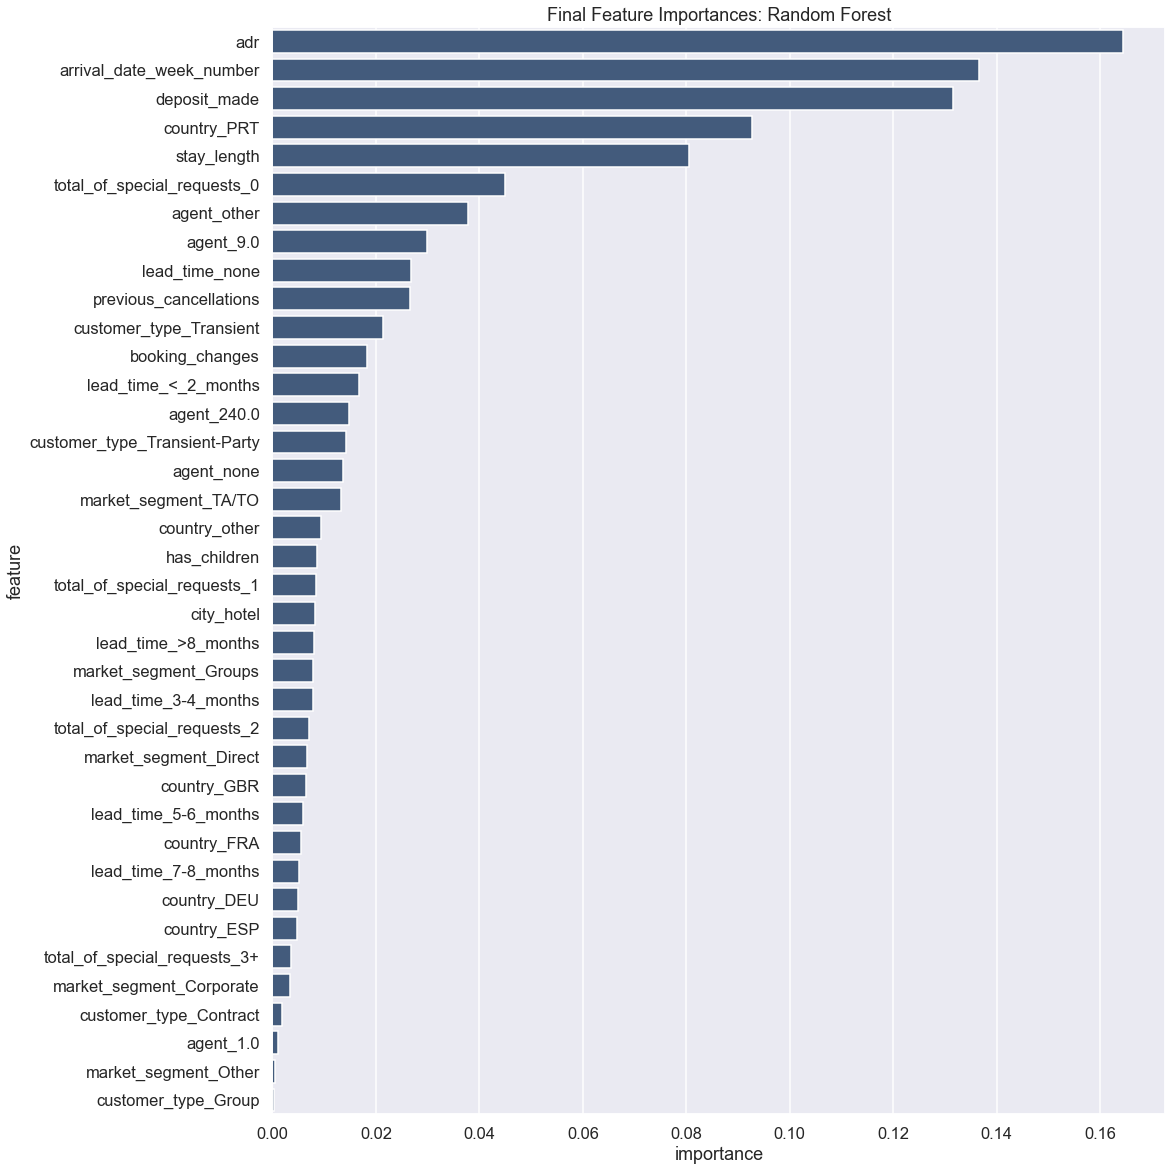

In [135]:
#Visualize feature importances
fig,ax = plt.subplots(figsize=(16,20))
sns.barplot(data=final_forest_features, 
            x='importance',
            y='feature',
            color = NEUTRAL)
plt.title('Final Feature Importances: Random Forest');

In [136]:
#Drop the un-importance features and reprocess the data
X_train_final = X_train_reduced.copy()
X_val_final = X_val_reduced.copy()

features_to_drop_final = ['has_children', 'stay_length']
X_train_reduced_final = X_train_final.drop(features_to_drop_final, axis=1)

cat_cols_reduced_final = X_train_reduced_final.select_dtypes('object').columns
num_cols_reduced_final = X_train_reduced_final.select_dtypes('number').columns

transformer_reduced_final = ColumnTransformer([
    ('num', num_transformer, num_cols_reduced_final),
    ('cat', cat_transformer, cat_cols_reduced_final),
    ])

preprocess_reduced_final = Pipeline([('transformer', transformer_reduced_final)])

X_train_reduced_processed_final = (preprocess_reduced_final
                                   .fit_transform(X_train_reduced_final))

X_val_reduced_final = X_val_reduced.drop(features_to_drop_final, axis=1)
X_val_reduced_processed_final = (preprocess_reduced_final
                                 .transform(X_val_reduced_final)
)

cat_names_reduced_final = (preprocess_reduced_final.named_steps['transformer']
             .transformers_[1][1].named_steps['ohe']
             .get_feature_names(cat_cols_reduced_final))
feature_names_reduced_final = (list(num_cols_reduced_final) 
                               + list(cat_names_reduced_final))

i_1f = len(num_cols_reduced_final)+1
i_2f = len(feature_names_reduced_final)

oversampler_f = SMOTENC(categorical_features = list(range(i_1f,i_2f)), 
                      n_jobs=-2, 
                      random_state=SEED)

In [137]:
X_train_final_file = 'files/X_train_final.pk1'
y_train_final_file = 'files/y_train_final.pk1'

if ('X_train_final.pk1' in os.listdir('files') and 
    'y_train_final.pk1' in os.listdir('files')):
    X_train_final = joblib.load(X_train_final_file)
    y_train_final = joblib.load(y_train_final_file)
else:
    X_train_final, y_train_final = oversampler_r.fit_resample(
    X_train_reduced_processed, y_train)
    joblib.dump(X_train_final, X_train_final_file)
    joblib.dump(y_train_final, y_train_final_file)
    
X_train_final.shape, y_train_final.shape

((104278, 36), (104278,))

In [138]:
forest_final_reduced_file = 'files/forest_final_reduced.pkl'

if 'forest_final_reduced.pkl' in os.listdir('files'):
    forest_final_reduced = joblib.load(forest_final_reduced_file)
else:
    forest_final_reduced = cross_validate(forest_best,
                    X_train_final,
                    y_train_final,
                    scoring=scoring,
                    cv=5,
                    return_train_score=True,
                    n_jobs=-2)
    joblib.dump(forest_final_reduced, forest_final_reduced_file)
forest_final_reduced

{'fit_time': array([325.23533607, 325.25728488, 325.22713304, 328.28100491,
        327.64985609]),
 'score_time': array([34.10893488, 34.21248603, 34.19457507, 38.18421793, 38.40256214]),
 'test_AUC': array([0.94161553, 0.94134016, 0.94360779, 0.96705469, 0.96742689]),
 'train_AUC': array([0.99902797, 0.99905821, 0.99906616, 0.99872111, 0.99869328]),
 'test_Accuracy': array([0.85692367, 0.85586881, 0.86119102, 0.89844162, 0.89757852]),
 'train_Accuracy': array([0.98771307, 0.9882525 , 0.98813263, 0.98453664, 0.98445273]),
 'test_Recall': array([0.83803222, 0.83486766, 0.84474492, 0.93008536, 0.93450326]),
 'train_Recall': array([0.98954712, 0.98997866, 0.99017046, 0.98655063, 0.98671813]),
 'test_Precision': array([0.87093881, 0.87147147, 0.87347546, 0.87471814, 0.87024469]),
 'train_Precision': array([0.98593063, 0.98657269, 0.98615124, 0.98259312, 0.9822673 ]),
 'test_F1': array([0.8541687 , 0.85277696, 0.85886998, 0.90155248, 0.90123   ]),
 'train_F1': array([0.98773557, 0.98827274

The removal of additional features increased the overfitting. Therefore, it makes sense to keep those features in.

### Model Thresholds

In [139]:
#Get the probabilities of the predictions on the validation set
probas = forest_best.predict_proba(X_val_reduced_processed)

In [140]:
#Verify target class order
forest_best.classes_

array([0, 1])

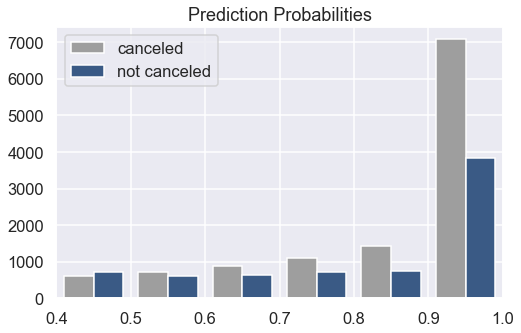

In [141]:
#Visualize probabilities
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(probas, color=[NEG,NEUTRAL])
plt.legend(['canceled', 'not canceled'])
plt.xlim(.4,1)
plt.title('Prediction Probabilities');

As evidenced in the graph above, the model misses many of the actual cancellations due to the imbalanced classes. I will explore changing the threshold to see if the model's performance can be improved. 

In [142]:
#Get the false positives, true positives and thresholds for the probabilities
fpr, tpr, thresholds = roc_curve(y_val, probas[:,1])
rates = pd.DataFrame(list(zip(tpr, fpr)))
rates.columns=['tpr', 'fpr']

#Select the values to highlight
high_pos = rates.iloc[4164]
low_false = rates.iloc[1]
t = int(np.where(thresholds==.5)[0])
balanced = (rates.iloc[t])

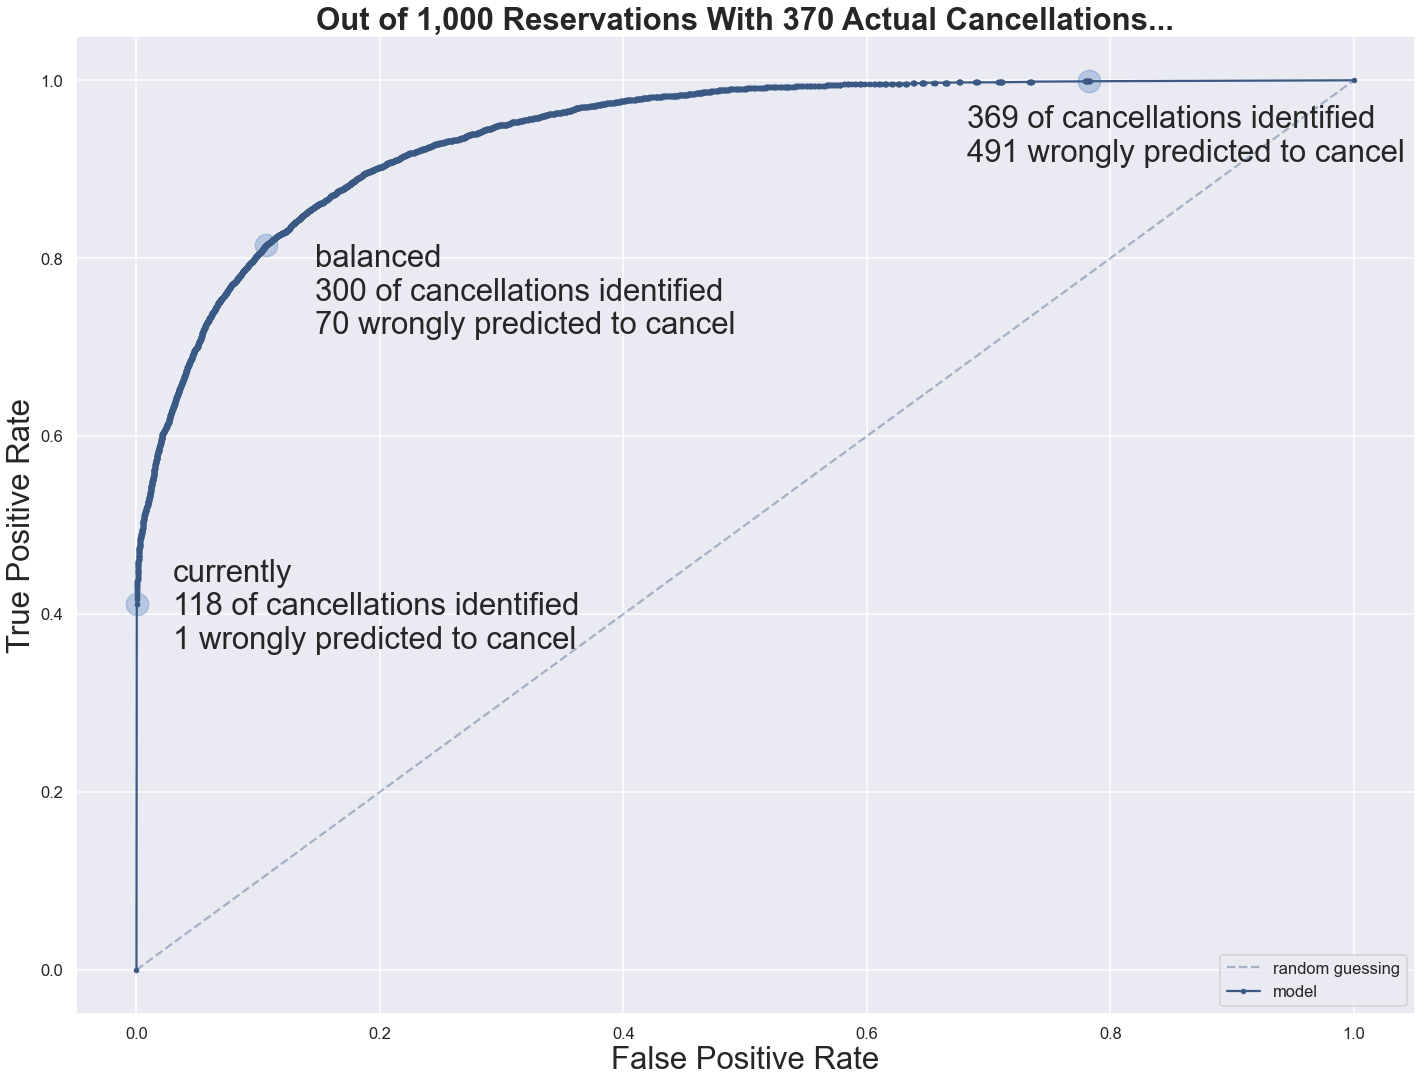

In [211]:
#Visualize the ROC curve
fig, ax = plt.subplots(figsize=(24,18))
plt.plot([0,1], [0,1], linestyle='--', label='random guessing', alpha=0.4)
plt.plot(fpr, tpr, marker='.', label='model', color=NEUTRAL)
plt.scatter(balanced[1], balanced[0], marker='o', color=WINTER, s=500)
plt.scatter(high_pos[1], high_pos[0], marker='o', color=WINTER, s=500)
plt.scatter(low_false[1], low_false[0], marker='o', color=WINTER, s=500)
plt.xlabel('False Positive Rate', fontsize='xx-large')
plt.ylabel('True Positive Rate', fontsize='xx-large')
plt.legend(loc='lower right')
plt.text(balanced[1]+.04, 
         balanced[0]-.1, 
 'balanced\n300 of cancellations identified\n70 wrongly predicted to cancel', 
         fontsize='xx-large')
plt.text(high_pos[1]-.1, 
         high_pos[0]-.09, 
         '369 of cancellations identified\n491 wrongly predicted to cancel',
        fontsize='xx-large')
plt.text(low_false[1]+.03, 
         low_false[0]-0.05, 
'currently\n118 of cancellations identified\n1 wrongly predicted to cancel',
        fontsize='xx-large')
plt.title('Out of 1,000 Reservations With 370 Actual Cancellations...', 
          fontsize='xx-large', fontweight='heavy');

In [144]:
#Use Youden’s J statistic to calculate the ideal threshold.
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.2f}')

Best Threshold: 0.41


In [145]:
print(f'With the best threshold of {best_thresh:.2f}, the fpr is \
{fpr[ix]:.2f} and the tpr is {tpr[ix]:.2f}.')

With the best threshold of 0.41, the fpr is 0.14 and the tpr is 0.85.


In [146]:
#Preditions on the validation set with the new threshold. 
y_pred_new_thresh = (forest_best.predict_proba(X_val_reduced_processed)[:,1]
                     >= best_thresh).astype(bool)

In [147]:
def get_score(y_true, y_pred):
    """Takes in actual and predicted y-values are returns accuracy, F1, recall
    and precision scores."""
    print(f'Accuracy: {accuracy_score(y_true,y_pred):.2f}')
    print(f'F1: {f1_score(y_true,y_pred):.2f}')
    print(f'Precision: {precision_score(y_true,y_pred):.2f}')
    print(f'Recall: {recall_score(y_true,y_pred):.2f}')

In [148]:
print(f'Original Threshold')
get_score(y_val, y_pred_forest)

Original Threshold
Accuracy: 0.86
F1: 0.82
Precision: 0.82
Recall: 0.81


In [149]:
print(f'New Threshold')
get_score(y_val, y_pred_new_thresh)

New Threshold
Accuracy: 0.86
F1: 0.82
Precision: 0.78
Recall: 0.85


The new threshold improved the recall while decreasing the precision. 

Out of 1,000 reservations with 370 actual cancellations,

Original threshold
- correctly identifies 300 of the cancellations
- wrongly predicts 70 cancellations

New threshold
- correctly identifies 315 of cancellations
- wrongly predicts 88 cancellations

So even though the new threshold identified 15 more cancellations, it came at a cost of 88 incorrect classifications.

As mentioned previously, in this case it is best to have a balance between precision and recall since this situation has arguments for both high precision and recall and there are no catastrophic consequences foreseen for either false positives or false negatives. I will use the original threshold because it has a better balance between these two metrics. 

### Model Metrics 

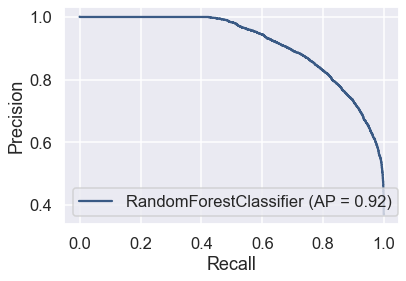

In [150]:
#Plot the precision-recall curve to verify current settings. 
plot_precision_recall_curve(forest_best, X_val_reduced_processed, y_val)

- Accuracy is 86%; the model is correct 86% of the time. This is a 62% improvement from the baseline model. 
- Precision is 0.82; of the predicted cancellations, the model is correct 82% of the time. This is a 127% from the baseline model. 
- Recall is 0.81; of the actual cancellations, the model identifies 81% of them. This is a 125% improvement from the baseline model. 

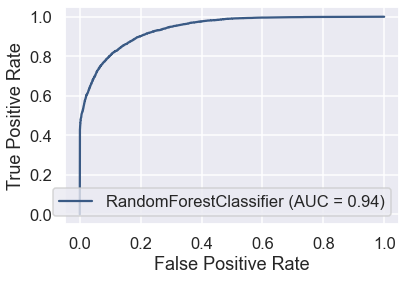

In [151]:
#Plot ROC curve and get the area under the curve.
plot_roc_curve(forest_best, X_val_reduced_processed, y_val)

- The AUC is 0.94; if a customer who cancels and one who does not cancel are randomly selected, there is a 94% likelihood that the model will assign a higher probability of canceling to the customer who ultimately cancels. This is an 88% improvement from the baseline model.

### Predictions on the Test Data

In [152]:
final_model = forest_best

#Process the test data by removing the unused features, one hot encoding the
# categorical variables and scaling the numerical features.
X_test = X_test.drop(features_to_drop, axis=1)
X_test_processed = preprocess_reduced.transform(X_test)

#Make predictions on the test data.
y_final_pred = final_model.predict(X_test_processed)

In [182]:
pd.DataFrame(classification_report(y_test, y_final_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.894803,0.895283,0.895043,11173.000000
1,0.821646,0.820896,0.821271,6566.000000
accuracy,0.867749,0.867749,0.867749,0.867749
macro avg,0.858225,0.858089,0.858157,17739.000000
weighted avg,0.867724,0.867749,0.867737,17739.000000


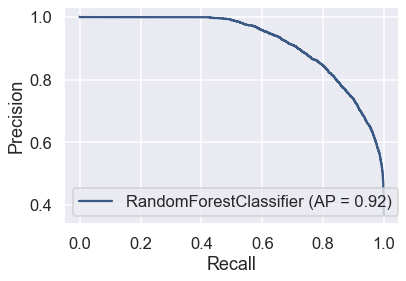

In [238]:
#Plot the precision-recall curve of the test data. 
plot_precision_recall_curve(forest_best, X_test_processed, y_test)

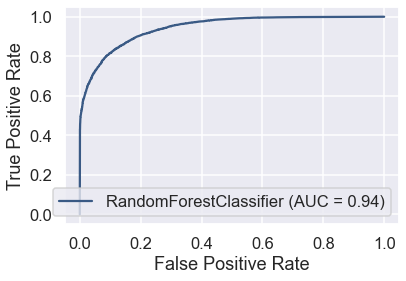

In [239]:
plot_roc_curve(forest_best, X_test_processed, y_test)

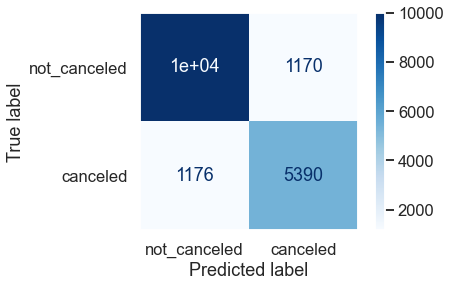

In [154]:
plot_confusion_matrix(final_model, 
                      X_test_processed, 
                      y_test,
                      display_labels=CLASS_NAMES,
                      cmap=plt.cm.Blues)
plt.grid(None)

The model's performance on the unseen test data was consistent with what was seen during training. 

# Conclusions and Recommendations

In [155]:
#Prepare dataframe for data summarization and visualization
hotels_final = hotels.copy()

#Change date string to datetime object.
hotels_final['reservation_status_date'] = pd.to_datetime(
    hotels_final['reservation_status_date'])

#Add weekends and weeknights together to get total stay length.
hotels_final['stay_length'] = (
    hotels_final['stays_in_weekend_nights'] +
    hotels_final['stays_in_week_nights']
)

#Add a column to show the date the reservation was made by using the status
#date, the lead time and the length of stay. 
hotels_final['booking_date'] = (hotels_final['reservation_status_date'] +
                               pd.to_timedelta(hotels_final['lead_time'], 
                                               unit='d') - 
                               pd.to_timedelta(hotels_final['stay_length'], 
                                               unit='d'))

#Create a dataframe of only customers who canceled.
canceled = hotels_final.copy()
canceled = canceled[hotels_final['is_canceled']==1]

#Create a dataframe of only customers who did not cancel.
not_canceled = hotels_final.copy()
not_canceled = not_canceled[hotels_final['is_canceled']==0]


## Value Added From the Cancellation Prediction Model

The hotel management company's current strategy for predicting cancellations is inferred through it's deposit strategy. 99% of customers who are charged a deposit go on to cancel. This indicates that the current strategy has a high precision rate - if a customer is predicted to cancel, they almost certainly will. However, the current strategy only identifies 32% of the customers that go on to cancel, which means the majority of cancellations are not associated with a deposit that can help buffer the potential loss in profits. 

The proposed model has a 156% improvement in identifying customers that will go on to cancel (of those that cancel, it correctly predicts 82% of them). The trade-off for this high recall is that there will be false positives - customers that are predicted to cancel but do not. Of those predicted to cancel, 18% do not. 

Overall, finding more of the cancellations is more important than being certain that every flagged reservation will ultimately cancel. The predictions will allow the hotel to be more responsive to changes in bookings and will provide opportunities to expand the deposit policy. The cost associated with the incorrectly flagged reservations is minimal, especially when the error rate is applied when modifying policy.

## How Cancellations Impact Profit

### 22% of Cancellations Occur Within 2 Weeks of Arrival

In [156]:
#Find percent of customers that book 60 days or more from arrival
lead = hotels_final['lead_time'].quantile(.465)
lead

60.0

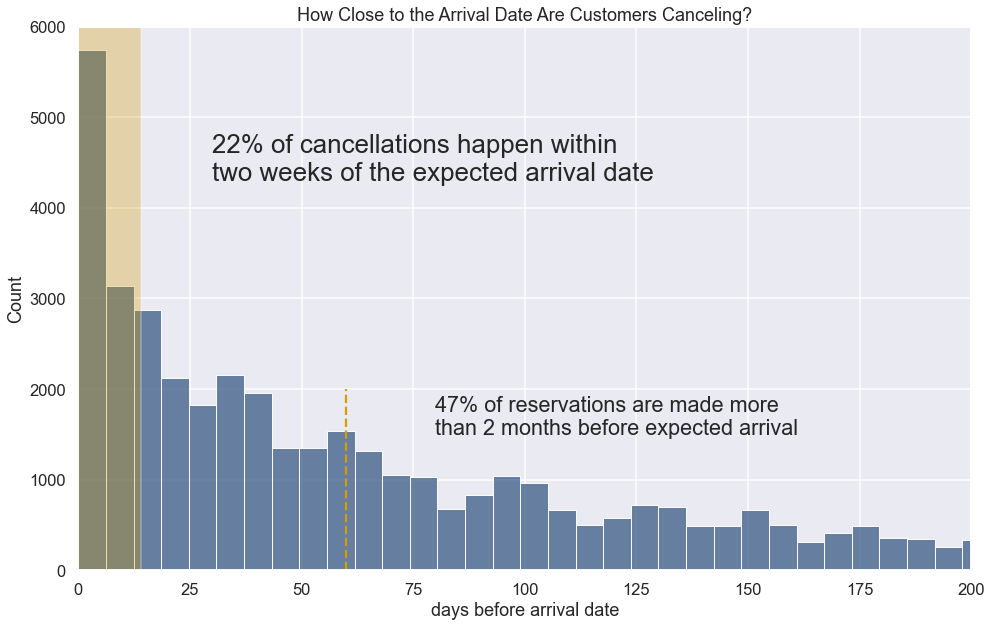

In [157]:
#Add a column to show how long before their predicted arrival date they made
#the cancellation.
canceled['canceled_days_before_arrival'] = (canceled['arrival_date'] - 
                                    canceled['reservation_status_date'])

canceled_days_before = (canceled['canceled_days_before_arrival'].
                        apply(lambda x: x/np.timedelta64(1, 'D')))
plt.subplots(figsize=(16,10))
sns.histplot(
    data=canceled_days_before
)
plt.xlabel('days before arrival date')
plt.title('How Close to the Arrival Date Are Customers Canceling?')
plt.vlines(
    lead, 
    linestyle='dashed', 
    color=FALL, 
    ymin=0, 
    ymax=2000
)
plt.xlim([0,200])
plt.ylim(0,6000)
plt.bar(
    x=0, 
    height=6000, 
    width=14, 
    align='edge', 
    color=FALL, 
    alpha=.3)
plt.text(30, 
         4300, 
'22% of cancellations happen within \ntwo weeks of the expected arrival date',
        fontsize='x-large')
plt.text(80,
        1500,
'47% of reservations are made more \nthan 2 months before expected arrival',
        fontsize= 'large');

In [158]:
#Lead time statistics
hotels_final['lead_time'].describe()

count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64

22% of cancellations occur within two weeks of the expected arrival date. Since almost half (47%) of customers are booking reservations 2 months or more before arrival, these last-minute cancellations are likely to result in vacancies and lost profit. 

### Each Cancellation Costs the Hotel an Average of €346.22

In [159]:
#Average daily rate, average stay length and average total cost per stay.
mean_rate = hotels_final['adr'].mean()
mean_stay = hotels_final['stay_length'].mean()

print(f'mean rate: { mean_rate:.2f}, mean stay length: {mean_stay:.2f}, \
mean cost of stay: {mean_rate*mean_stay:.2f}')

mean rate: 101.83, mean stay length: 3.43, mean cost of stay: 349.07


With an average daily rate of €101.83 and and average stay of 3.4 days, the hotel can expect to lost around €346.22 per cancellation if the room is not re-booked. 

### Cancellations Cut Into Profits More in the Slower Months

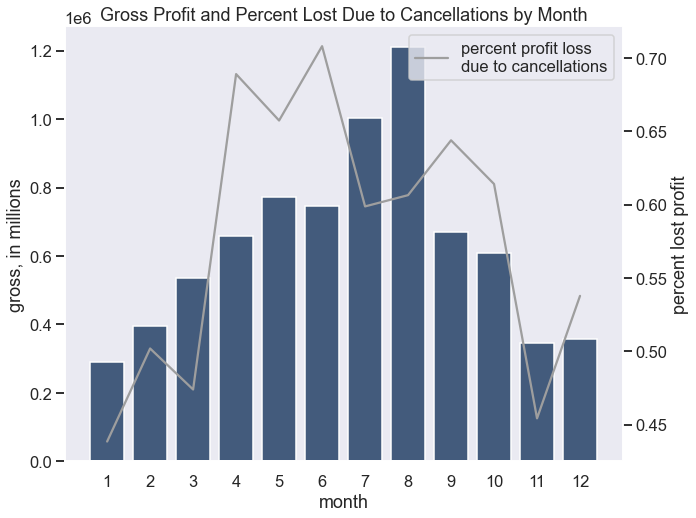

In [160]:
#Add arrival month column with month as a string
hotels_final['arrival_month'] = hotels_final['arrival_date'].dt.month
hotels_final['arrival_month'] = hotels_final['arrival_month'].astype('string')

#Add a constant column in order to get totals when using groupby
hotels_final['constant'] = 1

#Group by arrival month and calculate the number of stays, average daily rate,
#monthly gross, monthly lost profit and percent of all profit lost
by_month_stays = hotels_final.groupby('arrival_month').sum().reset_index()
by_month_stays['stays'] = (by_month_stays['constant'] - 
                           by_month_stays['is_canceled'])
by_month_stays['adr_month'] = by_month_stays['adr']/by_month_stays['constant']
by_month_stays['gross_month'] = (by_month_stays['adr_month'] * 
                                by_month_stays['stays'])
by_month_stays['lost_profit'] = (by_month_stays['adr_month'] * 
                                 by_month_stays['is_canceled'])
by_month_stays['percent_lost'] = (by_month_stays['lost_profit']/
                                  by_month_stays['gross_month'])
by_month_stays = by_month_stays.sort_values('arrival_month', 
                                            key= lambda x: x.astype('int'))

#Visualize the monthly gross and profit loss
fig,ax=plt.subplots(figsize=(10,8))
sns.barplot(
    data=by_month_stays, 
    x='arrival_month', 
    y='gross_month', 
    color=NEUTRAL
)
ax.set_ylabel('gross, in millions')
plt.xlabel('month')
ax2=ax.twinx()
sns.lineplot(
    data=by_month_stays, 
    x='arrival_month', 
    y='percent_lost', 
    color=NEG, 
    label='percent profit loss \ndue to cancellations'
)
ax2.set_ylabel('percent lost profit')
plt.title('Gross Profit and Percent Lost Due to Cancellations by Month')
ax.grid(False)
ax2.grid(False);

Cancellations peak in the summer months, but so do bookings. As a result, the potential loss due to cancellations are a smaller percentage of the gross profits during the busier months. The worst potential impact of cancellations on profits occurs in the spring and fall. 

## Identifying Customers Likely to Cancel

52.6% of the model's predictions come from four features: 

- average daily rate
- week of arrival date
- if a deposit was paid
- if the customer is a resident of Portugal

### Average Daily Rate

The average daily rate accounts for 16.4% of the model's prediction of a customer's likelihood of canceling. 

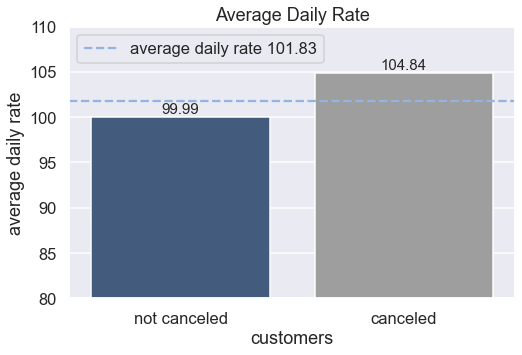

In [161]:
#Remove the outliers
canceled = canceled[canceled['adr']!=5400]
canceled_mean_adr = canceled['adr'].mean()

#Find the means of each class
not_canceled = not_canceled[not_canceled['adr'] >= 0]
not_canceled_mean_adr = not_canceled['adr'].mean()

#Visualize the average daily rate
x_adr = ['not canceled', 'canceled']
y_adr = [not_canceled_mean_adr, canceled_mean_adr]
fig,ax=plt.subplots(figsize=(8,5))
plots = sns.barplot(
                    x=x_adr,
                    y=y_adr,
                    palette=clr
)
ax.set_xlabel('customers')
ax.set_ylabel('average daily rate')
ax.set_title('Average Daily Rate')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(0, 8),
                       textcoords='offset points')
plt.axhline(
    hotels_final['adr'].mean(), 
    color=POS, 
    label='average daily rate 101.83',
    linestyle='dashed'
)
plt.legend(loc='upper left')
plt.ylim([80,110]);

In general, customers that canceled booked slightly more expensive rooms than average and customers that did not cancel booked rooms slightly less expensive than average. 

### Week of Arrival Date

The week of scheduled arrival accounts for 13.7% of the model's prediction of a customer's likelihood of canceling.

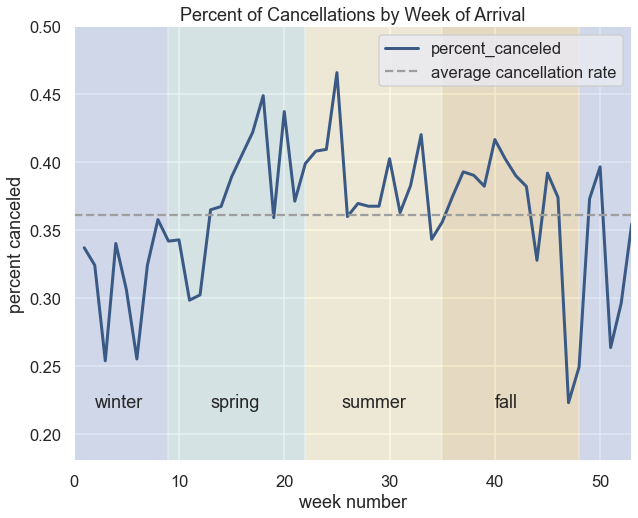

In [162]:
#Percent of reservations canceled by week. 
hotels_final['constant'] = 1
by_week = hotels_final.groupby('arrival_date_week_number').sum()
by_week['percent_canceled'] = by_week['is_canceled']/by_week['constant']
fig,ax = plt.subplots(figsize=(10,8))
by_week['percent_canceled'].plot(color=NEUTRAL, linewidth=3)
plt.ylabel('percent canceled')
plt.xlabel('week number')
plt.title('Percent of Cancellations by Week of Arrival')
plt.axhline(
    by_week['percent_canceled'].mean(), 
    color=NEG, 
    label='average cancellation rate', 
    linestyle = 'dashed'
)
plt.bar(
    x=0, 
    height=.5, 
    color=WINTER, 
    alpha=0.2, 
    width=9, 
    align='edge'
)
plt.bar(
    x=9, 
    height=.5, 
    color=SPRING, 
    alpha=0.2, 
    width=13, 
    align='edge'
)
plt.bar(
    x=22, 
    height=.5, 
    color=SUMMER, 
    alpha=0.2, 
    width=13, 
    align='edge'
)
plt.bar(
    x=35, 
    height=.5, 
    color=FALL, 
    alpha=0.2, 
    width=13, 
    align='edge'
)
plt.bar(
    x=48, 
    height=.5, 
    color=WINTER, 
    alpha=0.2, 
    width=5, 
    align='edge'
)
plt.xlim(0,53)
plt.ylim(.18,.5)
plt.legend()
plt.text(
    2, 
    .22, 
    'winter'
)
plt.text(
    13, 
    .22, 
    'spring'
)
plt.text(
    25.4, 
    .22, 
    'summer'
)
plt.text(
    40, 
    .22, 
    'fall'
);

The percent of reservations canceled is not constant throughout the year. It is at its lowest in the winter and peaks in the late spring and early summer. 

### Deposit

Deposits account for 13.2% of the model's prediction of a customer's likelihood of canceling. 

In [163]:
#Deposit types by cancellation status
canceled_deposits = (canceled['deposit_type']
                     .value_counts(normalize=True))
not_canceled_deposits = (not_canceled['deposit_type']
                         .value_counts(normalize=True))
deposits_overall = (hotels_final['deposit_type']
                    .value_counts(normalize=True))

print(f'Canceled Deposit Types: \n\n {canceled_deposits}')
print('\n\n\n')
print(f'Not-Canceled Deposit Types: \n\n {not_canceled_deposits}')
print('\n\n\n')
print(f'Overall Deposit Types: \n\n {deposits_overall}')

Canceled Deposit Types: 

 No Deposit    0.671461
Non Refund    0.327725
Refundable    0.000814
Name: deposit_type, dtype: float64




Not-Canceled Deposit Types: 

 No Deposit    0.997086
Refundable    0.001676
Non Refund    0.001237
Name: deposit_type, dtype: float64




Overall Deposit Types: 

 No Deposit    0.876464
Non Refund    0.122179
Refundable    0.001357
Name: deposit_type, dtype: float64


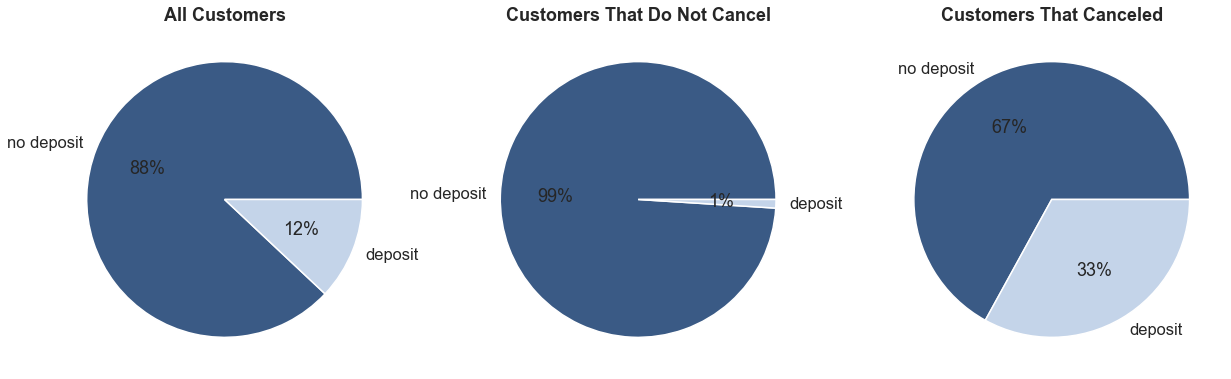

In [164]:
#Visualize the deposits by cancellation
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21,8))
labels=['no deposit', 'deposit']
ax1.pie(
    x=[.88,.12], 
    labels=labels, 
    autopct='%.0f%%', 
    colors = [NEUTRAL,WINTER]
)
ax1.set_title('All Customers', fontweight='bold')
ax2.pie(
    x=[.99,.01], 
    labels=labels, 
    autopct='%.0f%%', 
    colors = [NEUTRAL,WINTER]
)
ax2.set_title('Customers That Do Not Cancel', fontweight='bold')
ax3.pie(
    x=[.67,.33], 
    labels=labels, 
    autopct='%.0f%%', 
    colors = [NEUTRAL,WINTER]
)
ax3.set_title('Customers That Canceled', fontweight='bold');

In [165]:
# Cancellation by deposit paid
deposit_canceled = hotels_engineered[((hotels_engineered['deposit_made']==1)&
                    (hotels_engineered['is_canceled']==1))].shape[0]

deposit = hotels_engineered[(hotels_engineered['deposit_made']==1)].shape[0]

percent_deposit_canceled = deposit_canceled/deposit
print(f'Percentage of customers charged a deposit that canceled: \
      {percent_deposit_canceled:.3f}')

Percentage of customers charged a deposit that canceled:       0.985


It appears that the customers that are changed a deposit are indeed very likely to cancel, as almost 99% of reservations with a deposit did eventually cancel. Even so, two-thirds of customers that canceled were not charged a deposit. Of all deposits made, only 0.2% of them were refundable. 

### Resident of Portugal

A customer being a resident of Portugal accounts for 9.3% of the model's prediction of a customer's likelihood of canceling.

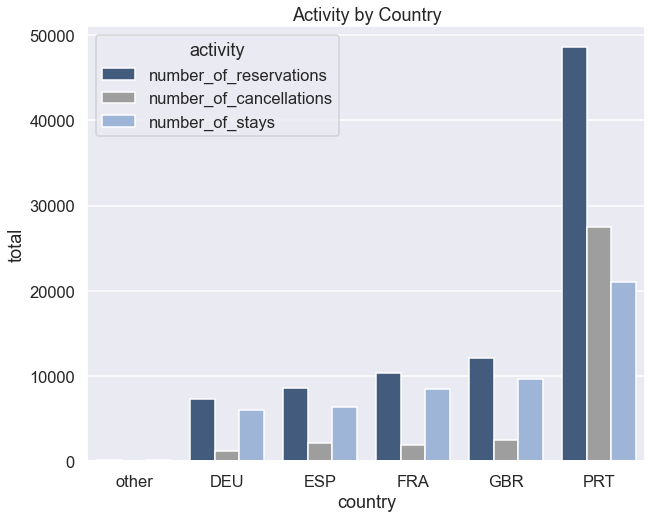

In [166]:
#Group by country and find the number of stays and cancellations
by_country = hotels_final.groupby('country').sum().reset_index()
by_country['country'] = by_country['country'].apply(country_group)
by_country['number_of_stays'] = (by_country['constant'] - 
                                 by_country['is_canceled'])

#Visualize the data
fig,ax=plt.subplots(figsize=(10,8))
by_country['percent_of_reservations'] = (by_country['constant']/
                                         hotels_final.shape[0])
by_country = (by_country[['country',
                          'constant',
                          'is_canceled', 
                          'number_of_stays']])
by_country.columns = (['country',
                       'number_of_reservations', 
                       'number_of_cancellations', 
                       'number_of_stays'])
df = pd.melt(
    by_country, 
    id_vars='country', 
    var_name='activity', 
    value_name='total'
)
sns.barplot(
    data=df, 
    x='country', 
    y='total', 
    hue='activity', 
    ci=None
)
plt.title('Activity by Country');

In [167]:
#Find the percent of stays and cancellations attributed to Portugal
total_stays = by_country['number_of_stays'].sum()
total_cancel = by_country['number_of_cancellations'].sum()
port_stays = by_country[by_country['country']=='PRT']['number_of_stays'].sum()
port_cancel = (by_country[by_country['country']=='PRT']
               ['number_of_cancellations'].sum())
port_percent_stays = round(port_stays/total_stays*100)
port_percent_cancel = round(port_cancel/total_cancel*100)
print(f'Residents of Portugal account for {port_percent_stays}% \
of hotel stays.')
print(f'Residents of Portugal account for {port_percent_cancel}% \
of hotel cancellations.')

Residents of Portugal account for 28.0% of hotel stays.
Residents of Portugal account for 62.0% of hotel cancellations.


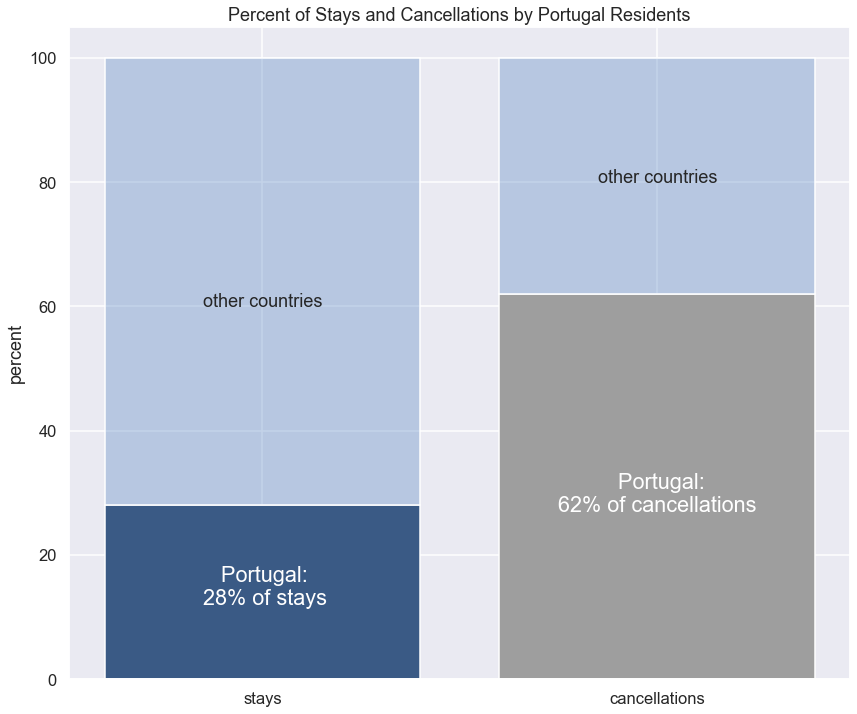

In [185]:
#Visualize the data for Portugal
fig, ax=plt.subplots(figsize=(14,12))
x_prt = ['stays', 'cancellations']
y_prt = [port_percent_stays, port_percent_cancel]
plt.bar(
    x=x_prt, 
    height=y_prt, 
    color=[NEUTRAL,NEG]
)
plt.bar(
    x=x_prt, 
    height=[100-port_percent_stays, 100-port_percent_cancel], 
    color=WINTER, 
    bottom=y_prt
)
plt.ylabel('percent')
plt.title('Percent of Stays and Cancellations by Portugal Residents')
plt.text(
    -.15, 
    12, 
    '   Portugal:\n28% of stays', 
    color=WHITE, 
    fontsize='large'
)
plt.text(
    -.15, 
    60, 
    'other countries', 
    fontsize='medium'
)
plt.text(
    .75, 
    27, 
    '          Portugal:\n62% of cancellations', 
    color=WHITE,
    fontsize='large'
)
plt.text(
    .85, 
    80, 
    'other countries', 
    fontsize='medium'
);

Over a quarter (28%) of all stays are by residents of Portugal. However, Portugal is the only country of residence where there are more cancellations than stays. Residents of Portugal are responsible for 62% of the cancellations. 

## What Can Be Done to Reduce the Impact of Cancellations

An average month has around 1,000 reservations.

Out of those 1,000 reservations,

- 370 are expected to cancel.
- 248 of the cancellations did not pay a deposit. 
- 229 of the cancellations were made by residents of Portugal.
- 81 of the cancellations occurred within 2 weeks of the expected arrival date.
- On average, each cancellation was booked for 3.5 nights at a rate of €104.84 per night, resulting in a total loss of €135,767.80 for the month if the rooms are not re-booked.


### Use predictions of future cancellations to make adjustments in marketing.

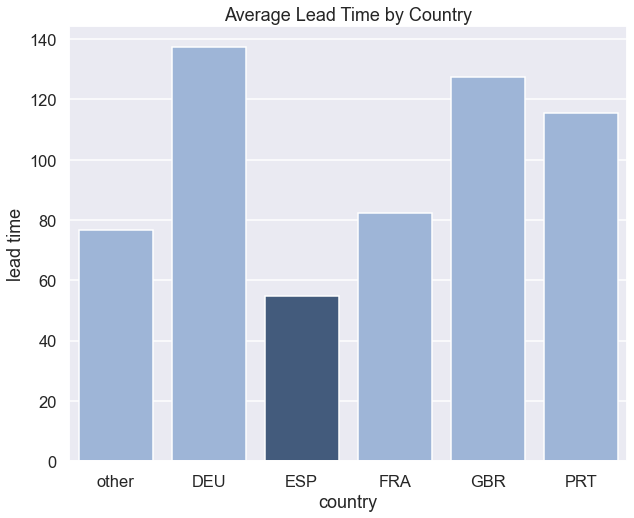

In [169]:
#Visualize the lead times by country
by_country_lead = hotels_final.groupby('country').mean().reset_index()
by_country_lead['country'] = by_country['country'].apply(country_group)
clrs = [NEUTRAL if (x < 20) else POS for x in by_country_lead['lead_time']]
fig,ax=plt.subplots(figsize=(10,8))
sns.barplot(
    data=by_country_lead, 
    x='country',
    y='lead_time', 
    palette=clrs, 
    ci=None
)
plt.ylabel('lead time')
plt.title('Average Lead Time by Country');

On average, residents of Spain book closer to the expected arrival date than residents of other countries. In months when cancellations are expected to be high, consider increasing marketing towards Spanish customers, who may be more likely to take advantage of last-minute openings.  

### Use predictions of future cancellations to make adjustments in wait-list and booking policies.

In [170]:
avg_wait = round(hotels_final['days_in_waiting_list'].mean())
print(f'Average number on days of waiting list: {avg_wait}')

Average number on days of waiting list: 2.0


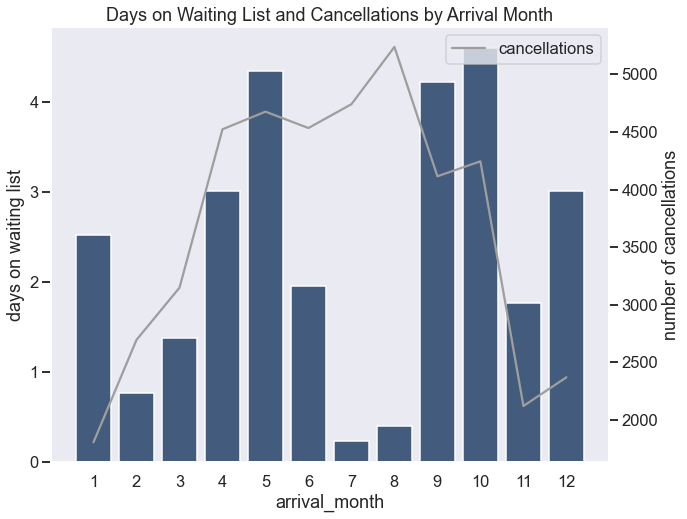

In [171]:
#Group by arrival month
by_month_wait = hotels_final.groupby('arrival_month').mean().reset_index()
by_month_wait = by_month_wait.sort_values('arrival_month', 
                                            key= lambda x: x.astype('int'))

#Visualize waitlist and cancellations by month
fig,ax=plt.subplots(figsize=(10,8))
sns.barplot(
    data=by_month_wait, 
    x='arrival_month', 
    y='days_in_waiting_list', 
    color=NEUTRAL
)
plt.ylabel('days on waiting list')
ax2=ax.twinx()
sns.lineplot(
    data=by_month_stays, 
    x='arrival_month', 
    y='is_canceled', 
    color=NEG, 
    label='cancellations'
)
ax2.set_ylabel('number of cancellations')
plt.xlabel('arrival month')
plt.title('Days on Waiting List and Cancellations by Arrival Month')
ax.grid(False)
ax2.grid(False);

In May, September and October, the number of cancellations are high and customers wait a longer than average time on the waiting list. Because customers that are put on the waiting list may elect to book another hotel rather than wait, consider overbooking a certain percentage of rooms during the months when the model predicts a higher-than-average number of cancellations.

### Update Deposit Requirements to Limit Profit Loss

#### Naive Approach

In [241]:
#Find percent of reservations that canceled, booked three months or more
#before arrival date and did not pay a deposit
add_deposit = hotels_final[((hotels_final['is_canceled']==1) 
              & (hotels_final['lead_time'] >= 90) 
              & (hotels_final['deposit_type']=='No Deposit'))]
num_dep = (add_deposit.shape[0]/hotels_final.shape[0])*100
num_dep

12.08727699137281

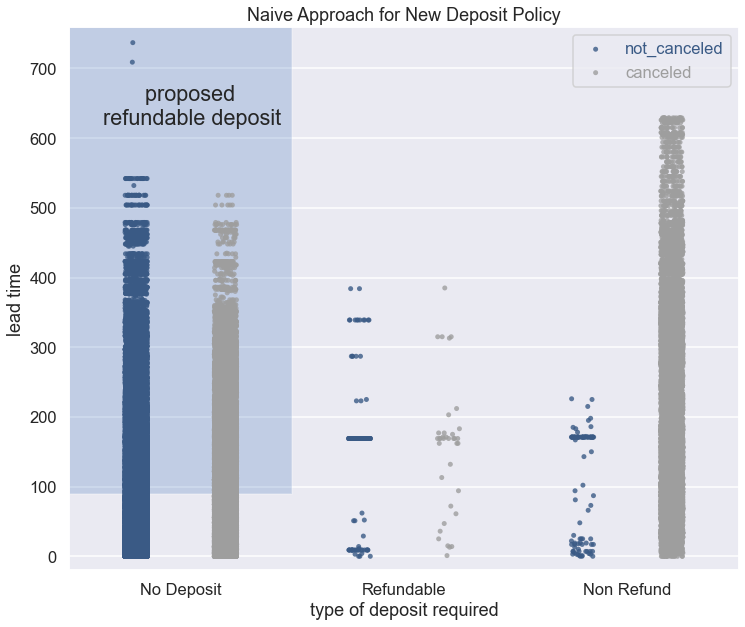

In [178]:
#Visualize the relationship between deposit types, lead times and cancellation
#status
fig,ax=plt.subplots(figsize=(12,10))
sns.stripplot(
    data=hotels_final, 
    x='deposit_type', 
    y='lead_time', 
    hue='is_canceled', 
    dodge=True, 
    alpha=0.8
)

plt.legend(labels=['not canceled','canceled'])
plt.xlabel('type of deposit required')
plt.ylabel('lead time')
plt.legend(labelcolor=[NEUTRAL, NEG], 
           labels=['not_canceled','canceled'], 
           loc='upper right')
plt.title('Naive Approach for New Deposit Policy')
plt.barh(
    90, 
    1, 
    height=700,
    color=WINTER, 
    alpha=.3, 
    align='edge', 
    left=-.5
)
plt.xlim(-.5, 2.5)
plt.ylim(-20, 760)
plt.text(-.35, 
         620, 
         '       proposed \nrefundable deposit', fontsize='large');

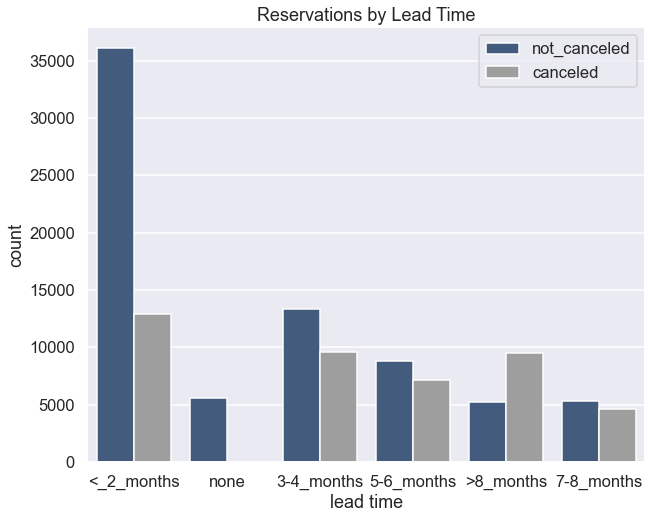

In [174]:
#Visualize the relationship between lead time and cancellations
fig,ax=plt.subplots(figsize=(10,8))
sns.countplot(
    data=hotels_engineered, 
    x='lead_time', 
    hue='is_canceled'
)
plt.legend(labels=['not_canceled', 'canceled'])
plt.xlabel('lead time')
plt.title('Reservations by Lead Time');

In [175]:
#Calculate the percent of customers who did not pay a deposit and booked
#three months or more before arrival
total_deposit = (
    hotels_final[(hotels_final['deposit_type']== 'No Deposit') & 
                 (hotels_final['lead_time'] >= 90)]
    .shape[0])/hotels_final.shape[0]
total_deposit

0.3327916910964067

In [176]:
#Calculate the percent of customers that did not pay a deposit that canceled
no_deposit_cancel = (
    hotels_final[(hotels_final['deposit_type']== 'No Deposit') & 
                 (hotels_final['lead_time'] >= 90) &
                hotels_final['is_canceled'] == 1].shape[0])
no_deposit_stay =  (
    hotels_final[(hotels_final['deposit_type']== 'No Deposit') & 
                 (hotels_final['lead_time'] >= 90) &
                hotels_final['is_canceled'] == 0].shape[0])

no_deposit_cancel/(no_deposit_cancel + no_deposit_stay)

0.12087276991372811

Continue charging non-refundable deposits for the customers that have already been identified to pay deposits. In addition, consider charging a refundable deposit (with the percent refunded based dependent upon how many days before arrival the customer cancels) for customers that book three months or more in advance. 

For example:
- Cancel 30 days or more from arrival date: 100% refund
- Cancel 15-29 days from arrival date: 80% refund
- Cancel 14 days or less from arrival: 60% refund

This would require a deposit from an additional 33% of customers than the original policy, where only 12% of these customers are expected to cancel.

#### Recommended Targeted Approach

In [206]:
#Find the number of customers who were predicted to cancel who did not pay
#a deposit
pred_df = pd.concat([X_val.reset_index(), 
                     pd.DataFrame(y_pred_forest)], axis=1)

pred_canceled_no_deposit = (
    pred_df[(pred_df[0]==1)&
            (pred_df['deposit_made']==0)]
    .shape[0]
)

pred_canceled = pred_df[pred_df[0]==1].shape[0]

percent_pred_deposit = pred_canceled_no_deposit/pred_canceled

percent_pred_deposit


0.6677365123032248

The model correctly predicts 82% of the actual cancellations (recall) and of those that canceled, only 33% paid a deposit. The model could be applied at the time of booking and if the customer is identified as one who is likely to cancel and is not already paying a deposit, a deposit can be required. This would require a deposit from an additional 20% of customers than the current policy, where the majority of those customers are expected to cancel. 

## Summary of Recommendations

- Use the model to make predictions of cancellations of current reservations

- During months when cancellation rates are predicted to be above average, increase marketing to residents of Spain, who are more likely to reserve a room with little advanced notice.

- Consider overbooking a percentage of rooms whenever cancellations are predicted to peek and the number of customers on a waiting list is increasing to minimize the time spent on waiting list and to take advantage of expected cancellations.

- Apply either a naive approach or a targeted approach with deposits. Naive: charge a refundable deposit to customers that are making reservations 3 months or more in advance. Targeted: Use the model at the time of booking to identify customers that are likely to cancel and charge them a deposit. Either of these may discourage last-minute cancellations and will help to recover some of the lost profit for cancellations that are unable to be re-booked.

# Future Work

- Obtain data on the number of vacant rooms each night in order to analyze the patterns in which cancellations lead to a room being re-booked and which ones result in vacancies. This information can be used to create more systematic responses to predicted cancellations. 

- Perform A/B testing on different refundable deposit strategies to determine impact of different deposit schedules on cancellation rates, cancellation timing and customer retention. 

- Once new deposit strategies are implemented, the model will need to be retrained, since the impact of this feature will change.

- Analyze data from 2020-2021 to determine how Covid has impacted cancellations. Specifically, look for ways that regional lockdowns effect cancellations and determine if these can be predicted and thus planned for. 
